# Homework 2: U-Net with Combined Loss and Advanced Augmentation

## Architecture
- **Base Model**: U-Net with custom layers and enhancements.
- **Contraction Path**: Includes convolutional layers with ReLU activation, dropout, batch normalization, and max pooling.
- **Bottleneck**: Uses parallel dilated convolutions, squeeze-excite block, and global context block.
- **Expansion Path**: Utilizes transposed convolutions, concatenation with skip connections, batch normalization, and ReLU activation.

## Parameters
- **Batch Size**: 32
- **Learning Rate**: 1e-3
- **Early Stopping Patience**: 40
- **Maximum Epochs**: 500
- **Number of Classes**: 5

## Data Preprocessing
- **Data Cleaning**: Removal of polluted images.
- **Data Augmentation**: Includes random flip, brightness, contrast, zoom and crop, Gaussian blur, edge enhancement, and more.

## Loss Functions
- **Combined Loss**: A combination of Dice Loss, Focal Loss, and Boundary Loss with specific weights.
  - **Dice Weight**: 1.5
  - **Focal Weight**: 2.0
  - **Boundary Weight**: 0.5

## Callbacks
- **Early Stopping**: Monitors `val_mean_iou` with patience of 40 epochs.
- **ReduceLROnPlateau**: Reduces learning rate by a factor of 0.35 if `val_mean_iou` does not improve for 25 epochs.
- **Visualization Callback**: Visualizes predictions every 5 epochs.

## Class Weights
- **Class Weights Calculation**: Standard, adjusted with median, and capped at a value of 10.
- **Final Weights**: Excludes the background class (class 0).

In [1]:
# To clean the img folder
# %rm img/*

## Check production env

In [2]:
import os
# Check if we are in Google Colab

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# check if we are in Kaggle

IN_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ


In [3]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/gdrive")
    %cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

## ⚙️ Import Libraries

In [4]:
# Install albumentations
!pip install -q -U albumentations

In [5]:
SAVE_IMAGES = False

seed = 12051985

import re, time
from datetime import datetime
import random

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import albumentations as A
import tqdm as notebook_tqdm

import keras_cv

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


In [6]:
# Global counter for plot numbering
plot_counter = 0

# Create img directory if it doesn't exist
if SAVE_IMAGES:
    if not os.path.exists('img'):
        os.makedirs('img')

# Original show function
original_show = plt.show

def save_and_show():
    def custom_show(*args, **kwargs):
        global plot_counter
        plot_counter += 1

        # Get current figure and its title
        current_fig = plt.gcf()
        title = current_fig._suptitle
        if title:
            # Clean title for filename
            title_text = re.sub(r'[^\w\s-]', '', title.get_text()).strip()
            title_text = re.sub(r'[-\s]+', '_', title_text)
            filename = f'img/{plot_counter:03d}_{title_text}.pdf'
        else:
            filename = f'img/{plot_counter:03d}.pdf'

        # Save figure
        current_fig.savefig(filename, format='pdf', bbox_inches='tight')
        print(f"Saved plot to {filename}")

        # Call original show function
        return original_show(*args, **kwargs)

    # Replace plt.show with custom function
    plt.show = custom_show

if SAVE_IMAGES:
    # Initialize the callback
    save_and_show()

## ⏳ Load the Data

In [7]:
if IN_KAGGLE:
    data = np.load('/kaggle/input/mars-homework-2/mars_for_students.npz')
else:
    data = np.load("../mars_for_students.npz") #remember to change the path accordingly to your folder

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [8]:
# Set batch size for training
BATCH_SIZE = 32

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 40

# Set maximum number of training epochs
EPOCHS = 500

# Set data split size for training and validation
SPLITS_SIZE = 300

# Set the number of classes
NUM_CLASSES = 5

# 🏋🏻‍♂️ Data preprocessing

In [9]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


# 👽 Data cleaning

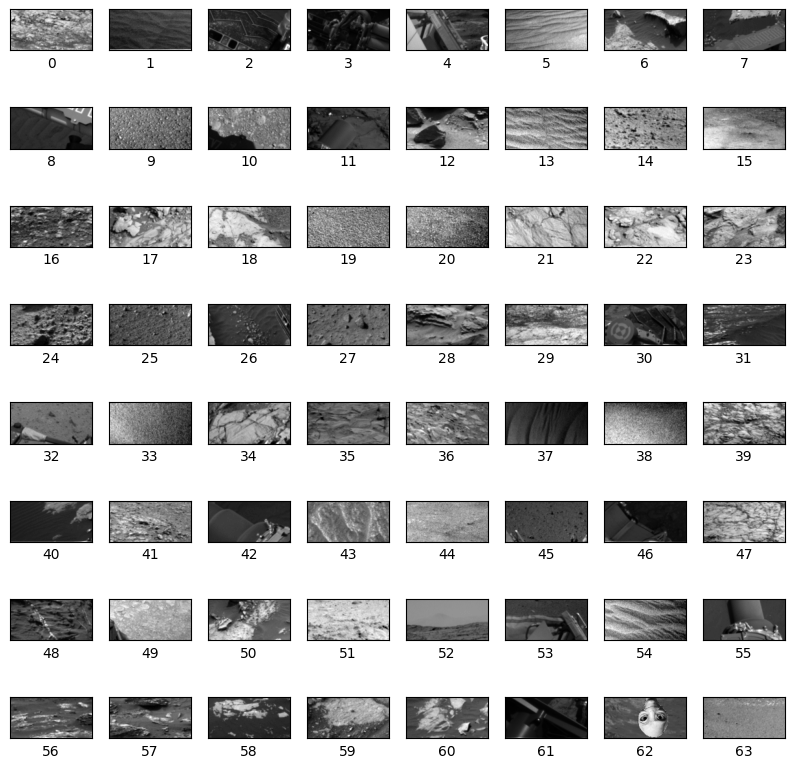

In [10]:
#pot the first 64 images (8x8) in a grid and attach the index of the image as title
plt.figure(figsize=(10, 10))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i, :, :, 0], cmap='gray')
    plt.xlabel(i)
plt.show()

In [11]:
polluted_mask_idx = 62
polluted_mask = y_train[polluted_mask_idx]

print(f"Polluted mask index: {polluted_mask.shape}")

polluted_mask_indices = []
for i, mask in enumerate(y_train):
    if np.array_equal(mask, polluted_mask):
        polluted_mask_indices.append(i)

print(f"Polluted mask indices: {polluted_mask_indices}")
print(f"Number of polluted masks: {len(polluted_mask_indices)}")

Polluted mask index: (64, 128)
Polluted mask indices: [62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]
Number of polluted masks: 110


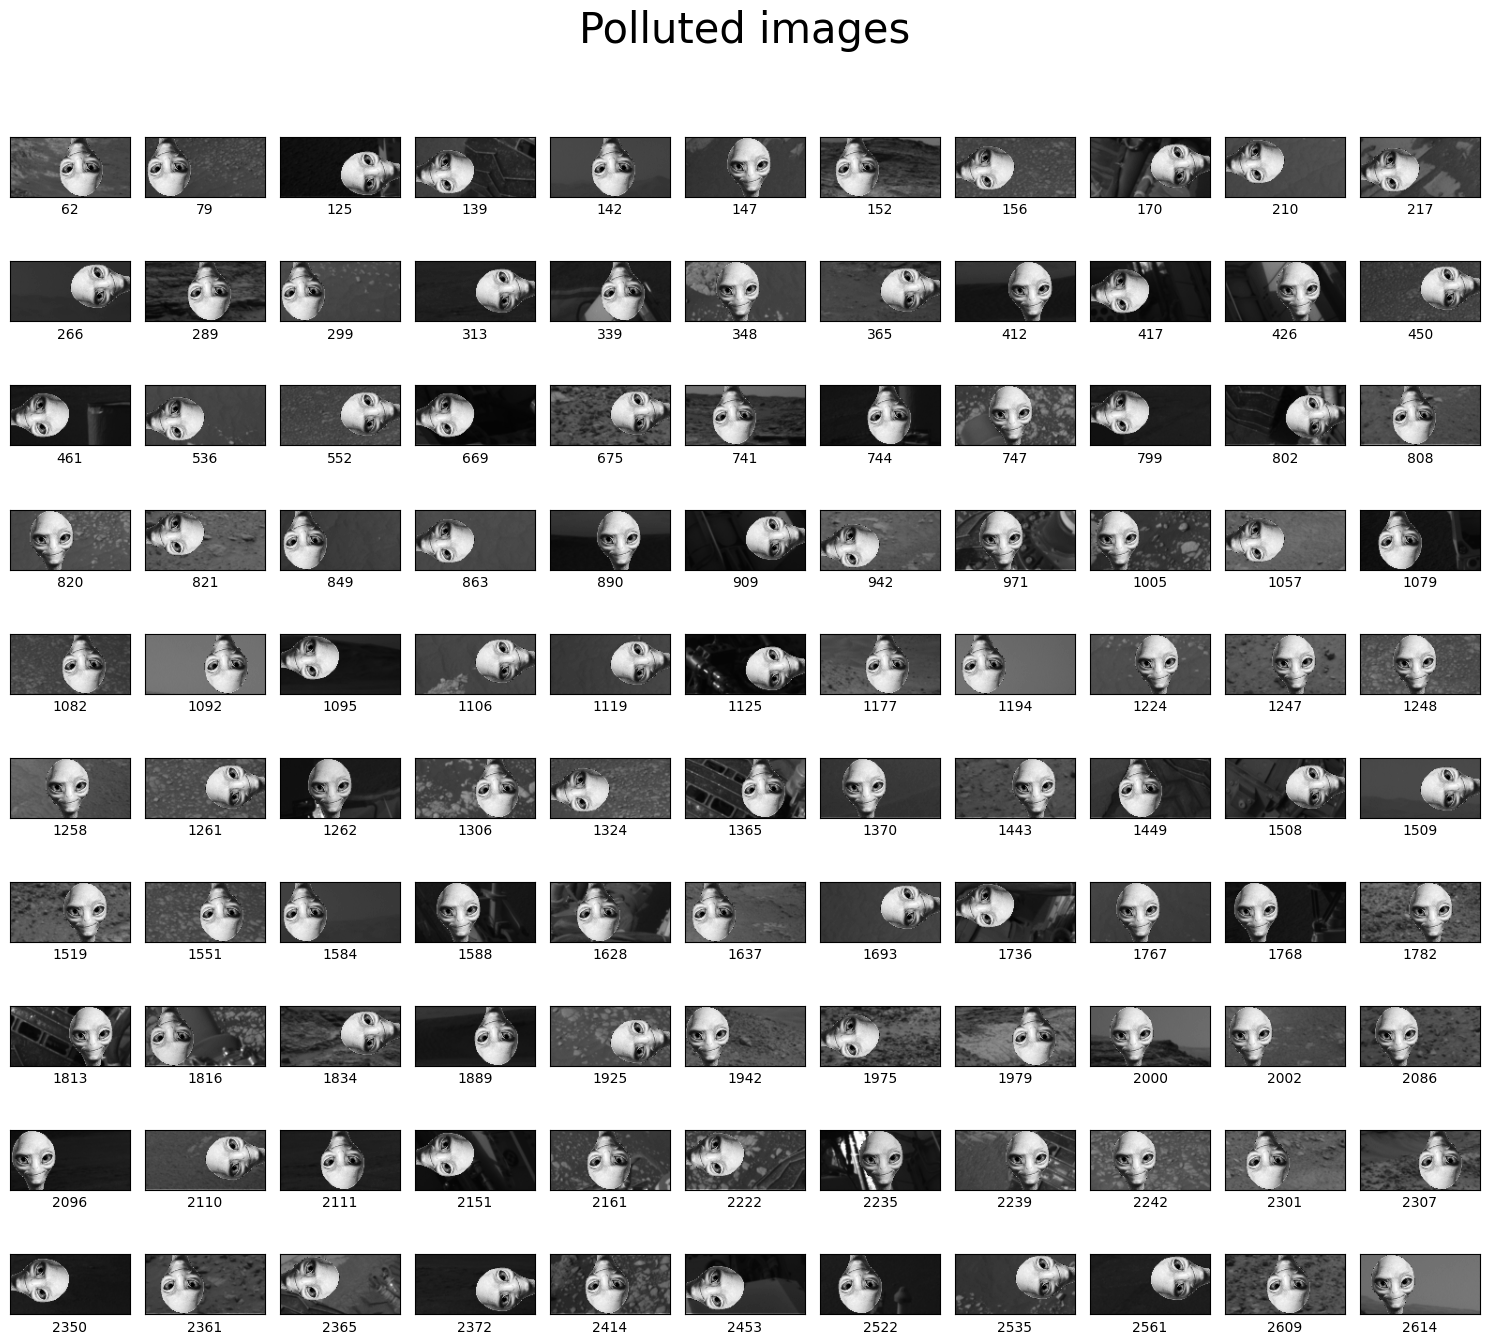

In [12]:
plt.figure(figsize=(15, 15))
num_images = len(polluted_mask_indices)
grid_size = int(np.ceil(np.sqrt(num_images)))

for i, idx in enumerate(polluted_mask_indices):
    plt.subplot(grid_size, grid_size, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[idx, :, :, 0], cmap='gray')
    plt.xlabel(idx)

plt.suptitle("Polluted images", fontsize=30)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [13]:
# Now remove from the x_train of polluted images using the polluted_mask_indices
X_train_clean = np.delete(X_train, polluted_mask_indices, axis=0)
y_train_clean = np.delete(y_train, polluted_mask_indices, axis=0)

print(f"X_train_clean shape: {X_train_clean.shape}")
print(f"y_train_clean shape: {y_train_clean.shape}")

X_train_clean shape: (2505, 64, 128, 1)
y_train_clean shape: (2505, 64, 128)


# Data distribution

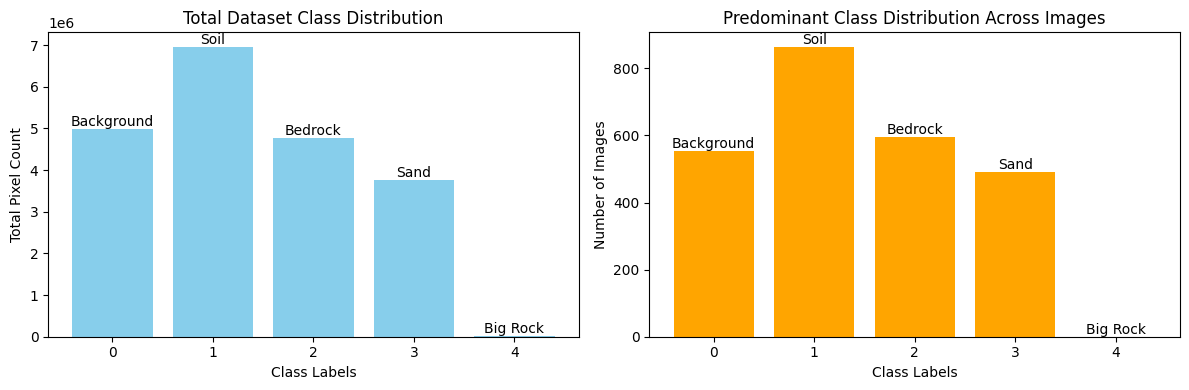

In [14]:

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def analyze_label_distribution(y_train_clean):
    NUM_CLASSES = 5  # Number of classes
    class_names = ['Background', 'Soil', 'Bedrock', 'Sand', 'Big Rock']
    
    total_class_counts = Counter()
    predominant_classes = []

    # Calculate class distribution and predominant class for each image
    for mask in y_train_clean:
        class_counts = Counter(mask.flatten())
        predominant_class = max(class_counts, key=class_counts.get)
        predominant_classes.append(predominant_class)

        # Update total counts
        for label, count in class_counts.items():
            total_class_counts[label] += count

    # Plot overall class distribution
    labels, counts = zip(*sorted(total_class_counts.items()))
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    bars = plt.bar(labels, counts, color='skyblue')
    plt.xticks(range(NUM_CLASSES), range(NUM_CLASSES))
    plt.xlabel('Class Labels')
    plt.ylabel('Total Pixel Count')
    plt.title('Total Dataset Class Distribution')

    # Add class names on top of each bar using loop index
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{class_names[i]}', ha='center', va='bottom')

    # Analyze predominant classes
    predominant_class_counts = Counter(predominant_classes)
    plt.subplot(1, 2, 2)
    bars = plt.bar(range(NUM_CLASSES), [predominant_class_counts.get(i, 0) for i in range(NUM_CLASSES)], color='orange')
    plt.xticks(range(NUM_CLASSES), range(NUM_CLASSES))
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Images')
    plt.title('Predominant Class Distribution Across Images')

    # Add class names on top of each bar using loop index
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{class_names[i]}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Return summary statistics
    return {
        'total_class_distribution': total_class_counts,
        'predominant_class_distribution': predominant_class_counts
    }
#Call the plot_label_distribution function to plot the label distribution of the training set and get the predominant classes for each image in the training set
predominant_classes = analyze_label_distribution(y_train_clean)

## Class Weights

In [15]:
from sklearn.utils.class_weight import compute_class_weight
#STANDARD WEIGHT CALCULATION
def calculate_class_weights(y_train_clean, num_classes):
    # Flatten all masks into a single array to calculate pixel-level class frequencies
    all_pixels = np.concatenate([mask.flatten() for mask in y_train_clean])

    # Compute class weights using sklearn
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.arange(num_classes),
        y=all_pixels
    )

    # Convert to dictionary format for easier usage
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    return class_weight_dict
#Call the calculate_class_weights function to calculate the class weights for the training set
class_weights = calculate_class_weights(y_train_clean, NUM_CLASSES)     
print(f"Class weights: {class_weights}")

#ADJUSTED WEIGHT CALCULATION
def adjust_weights_with_median(class_weights):
    # Get the median of the class weights
    median_weight = np.median(list(class_weights.values()))

    # Scale all weights relative to the median
    adjusted_weights = {cls: weight / median_weight for cls, weight in class_weights.items()}
    return adjusted_weights
adjusted_weights = adjust_weights_with_median(class_weights)
print("Adjusted Class Weights:", adjusted_weights)

#CAP WEIGHTS CALCULATION
def cap_weights(class_weights, cap_value):
    capped_weights = {cls: min(weight, cap_value) for cls, weight in class_weights.items()}
    return capped_weights
capped_weights = cap_weights(adjusted_weights, cap_value=10)
print("Capped Class Weights:", capped_weights)

Class weights: {0: 0.8226769183771894, 1: 0.5898914242365618, 2: 0.8591909663562084, 3: 1.088407490884616, 4: 152.21570300040796}
Adjusted Class Weights: {0: 0.9575018250786859, 1: 0.6865661387692026, 2: 1.0, 3: 1.2667818139435345, 4: 177.16166598672254}
Capped Class Weights: {0: 0.9575018250786859, 1: 0.6865661387692026, 2: 1.0, 3: 1.2667818139435345, 4: 10}


# ⛏️ Datasets creation

In [16]:
from sklearn.model_selection import train_test_split

# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")
train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    X_train_clean, y_train_clean, test_size=SPLITS_SIZE, random_state=seed
)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=SPLITS_SIZE, random_state=seed
)
print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(train_img)}")
print(f"Validation: {len(val_img)}")
print(f"Test: {len(test_img)}")

Splitting data...
Data splitted!

Number of images:
Train: 1905
Validation: 300
Test: 300


In [17]:
# Image augmentation

@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label


@tf.function
def random_brightness(image, label, seed=None):
    """Random brightness with safeguards."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    # Reduced max_delta to avoid overly dark images
    image = tf.image.random_brightness(image, max_delta=0.05, seed=seed)
    # Ensure pixel values are clipped between 0 and 1
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

@tf.function
def random_contrast(image, label, seed=None):
    """Random contrast with safeguards."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    # Adjusted range for contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2, seed=seed)
    # Ensure pixel values are clipped between 0 and 1
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

@tf.function
def random_flip_up_down(image, label, seed=None):
    """Random flip up-down."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_up_down(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_up_down(label),
        lambda: label
    )
    return image, label

@tf.function
def advanced_keras_cv(image, label, seed=None):
    """GridMask data augmentation."""
    flip_prob = tf.random.uniform([], seed=seed)

    image = tf.cond(
        flip_prob > 0.5,
        lambda: keras_cv.layers.RandomCutout(width_factor = 0.5, height_factor = 0.3, fill_value = 0.0)(image),
        lambda: image
    )

    image = tf.cond(
        flip_prob > 0.3,
        lambda: keras_cv.layers.GridMask()(image),
        lambda: image
    )

    # Ensure masks only undergo spatial transformations
    label = tf.image.resize_with_crop_or_pad(label, image.shape[0], image.shape[1])
    # Ensure label remains integer
    # label = tf.cast(label, tf.int32)
    
    return image, label

@tf.function
def random_zoom_and_crop(image, label, seed=None):
    """Random zoom and crop maintaining semantic segmentation alignment"""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    
    # Target size
    target_height, target_width = 64, 128
    
    # Random zoom factor between 1.0-2.0x
    zoom = tf.random.uniform([], 1.0, 2.0, seed=seed)
    
    # Calculate new dimensions
    orig_height = tf.cast(tf.shape(image)[0], tf.float32)
    orig_width = tf.cast(tf.shape(image)[1], tf.float32)
    
    new_height = tf.cast(orig_height * zoom, tf.int32)
    new_width = tf.cast(orig_width * zoom, tf.int32)
    
    def apply_zoom_crop():
        # Resize both image and label with same parameters
        zoomed_image = tf.image.resize(
            image, 
            [new_height, new_width],
            method='bilinear'
        )
        zoomed_label = tf.image.resize(
            label,
            [new_height, new_width],
            method='nearest'  # Preserve label values
        )
        
        # Random crop offsets
        max_offset_height = new_height - target_height
        max_offset_width = new_width - target_width
        
        offset_height = tf.random.uniform(
            [], 0, max_offset_height + 1,
            dtype=tf.int32, seed=seed
        )
        offset_width = tf.random.uniform(
            [], 0, max_offset_width + 1,
            dtype=tf.int32, seed=seed
        )
        
        # Apply same crop to both
        cropped_image = tf.image.crop_to_bounding_box(
            zoomed_image, offset_height, offset_width,
            target_height, target_width
        )
        cropped_label = tf.image.crop_to_bounding_box(
            zoomed_label, offset_height, offset_width,  
            target_height, target_width
        )
        
        return cropped_image, cropped_label
    
    # Apply transform with 50% probability
    should_transform = tf.random.uniform([], seed=seed) > 0.5
    image, label = tf.cond(
        should_transform,
        apply_zoom_crop,
        lambda: (image, label)
    )
    
    # Ensure output shapes
    image.set_shape([target_height, target_width, 1])
    label.set_shape([target_height, target_width, 1])
    
    return image, label

# Add gaussian blur
@tf.function
def random_gaussian_blur(image, label, seed=None):
    """Random Gaussian blur with safeguards."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    # Apply transform with 50% probability
    should_transform = tf.random.uniform([], seed=seed) > 0
    kernel_size_x = tf.random.uniform([], minval=1, maxval=10, dtype=tf.int32, seed=seed)
    kernel_size_y = tf.random.uniform([], minval=1, maxval=10, dtype=tf.int32, seed=seed)
    image = tf.cond(
        should_transform,
        lambda: keras_cv.layers.RandomGaussianBlur(kernel_size=(kernel_size_x, kernel_size_y), factor=(0.9, 0.9))(image),
        lambda: image
    )
    return image, label

# Sobel filter (edge detection)
@tf.function
def random_sobel_filter(image, label, seed=None):
    """Random Sobel filter with safeguards."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    # Apply transform with 50% probability
    should_transform = tf.random.uniform([], seed=seed) > 0
    image = tf.cond(
        should_transform,
        lambda: tf.image.sobel_edges(tf.expand_dims(image, axis=0)),
        lambda: tf.expand_dims(image, axis=0)
    )
    image = tf.squeeze(image, axis=0)
    # Combine the two channels to get a single channel image
    image = tf.sqrt(tf.reduce_sum(tf.square(image), axis=-1))
    image = tf.expand_dims(image, axis=-1)
    return image, label

# Edge enhance
@tf.function
def random_edge_enhance(image, label, seed=None):
    """Enhance edges by blending Sobel filter with original image"""
    if seed is None:
        seed = tf.random.uniform([], maxval=1000000, dtype=tf.int32)
    
    def apply_edge_enhance():
        # Apply Sobel filter to get edges
        edges = tf.image.sobel_edges(tf.expand_dims(image, axis=0))
        edges = tf.squeeze(edges, axis=0)  # Shape: [H, W, C, 2]
        
        # Calculate edge magnitude
        edge_magnitude = tf.sqrt(tf.reduce_sum(tf.square(edges), axis=-1))
        edge_magnitude = edge_magnitude / (tf.reduce_max(edge_magnitude) + 1e-8)
        # edge_magnitude shape: [H, W, C]
        
        # Random blend factor
        alpha = tf.random.uniform([], 0.3, 0.7, seed=seed)
        
        # Blend original image with edge magnitude
        enhanced = (1.0 - alpha) * image + alpha * edge_magnitude
        enhanced = tf.clip_by_value(enhanced, 0.0, 1.0)
        
        return enhanced
    
    # Apply enhancement with 40% probability
    should_transform = tf.random.uniform([], seed=seed) < 0.4
    image = tf.cond(
        should_transform,
        apply_edge_enhance,
        lambda: image
    )
    
    # Ensure the output shape matches the input
    image.set_shape(image.shape)
    
    return image, label

# edge reduce
@tf.function
def random_edge_reduce(image, label, seed=None):
    """Reduce edges by subtracting Sobel filter from original image"""
    if seed is None:
        seed = tf.random.uniform([], maxval=1000000, dtype=tf.int32)
    
    def apply_edge_reduce():
        # Apply Sobel filter to get edges
        edges = tf.image.sobel_edges(tf.expand_dims(image, axis=0))
        edges = tf.squeeze(edges, axis=0)

        # Calculate edge magnitude
        edge_magnitude = tf.sqrt(tf.reduce_sum(tf.square(edges), axis=-1))
        edge_magnitude = edge_magnitude / (tf.reduce_max(edge_magnitude) + 1e-8)

        # Random blend factor
        alpha = tf.random.uniform([], 0.3, 0.7, seed=seed)

        # Reduce original image with edge magnitude
        reduced = image - alpha * edge_magnitude
        reduced = tf.clip_by_value(reduced, 0.0, 1.0)

        return reduced
    
    # Apply reduction with 40% probability
    should_transform = tf.random.uniform([], seed=seed) < 0.3
    image = tf.cond(
        should_transform,
        apply_edge_reduce,
        lambda: image
    )

    # Ensure the output shape matches the input
    image.set_shape(image.shape)
    return image, label

@tf.function
def random_sharpness(image, label, seed=None):
    """Random sharpness augmentation with keras_cv.layers.RandomSharpness."""
    # if seed is None:
    #     seed = np.random.randint(0, 1000000)
    
    sharpness_layer = keras_cv.layers.RandomSharpness(factor=(1,1), value_range=(0, 1))
    
    image = tf.cond(
        tf.random.uniform([], ) < 0.3,
        lambda: sharpness_layer(image),
        lambda: image
    )
    
    # Ensure pixel values are clipped between 0 and 1
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, label


@tf.function
def clip_values(image, label):
    """Clip pixel values between 0 and 1."""
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

In [18]:
@tf.function
def augment_image(image, label, seed=None):
    """Apply augmentation to image."""

    # Ensure inputs have channel dimension
    if len(tf.shape(image)) < 3:
        image = tf.expand_dims(image, axis=-1)
    if len(tf.shape(label)) < 3:
        label = tf.expand_dims(label, axis=-1)
        
    image = tf.cast(image, tf.float32)
    image, label = random_flip(image, label, seed)
    image, label = random_brightness(image, label, seed)
    image, label = random_contrast(image, label, seed)
    image, label = random_flip_up_down(image, label, seed)
    image, label = clip_values(image,label)
    image, label = random_zoom_and_crop(image, label, seed)
    # image, label = random_edge_enhance(image, label, seed)
    # image, label = random_gaussian_blur(image, label, seed)
    image, label = advanced_keras_cv(image, label, seed)
    # image, label = random_sobel_filter(image, label, seed)
    # image, label = random_edge_reduce(image, label, seed)
    image, label = random_sharpness(image, label, seed)

    return image, label

In [19]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from numpy arrays
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    if augment:
        dataset = dataset.map(
            lambda x, y: augment_image(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


In [20]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (32, 64, 128, 1)
Labels shape: (32, 64, 128, 1)
Labels dtype: <dtype: 'float64'>


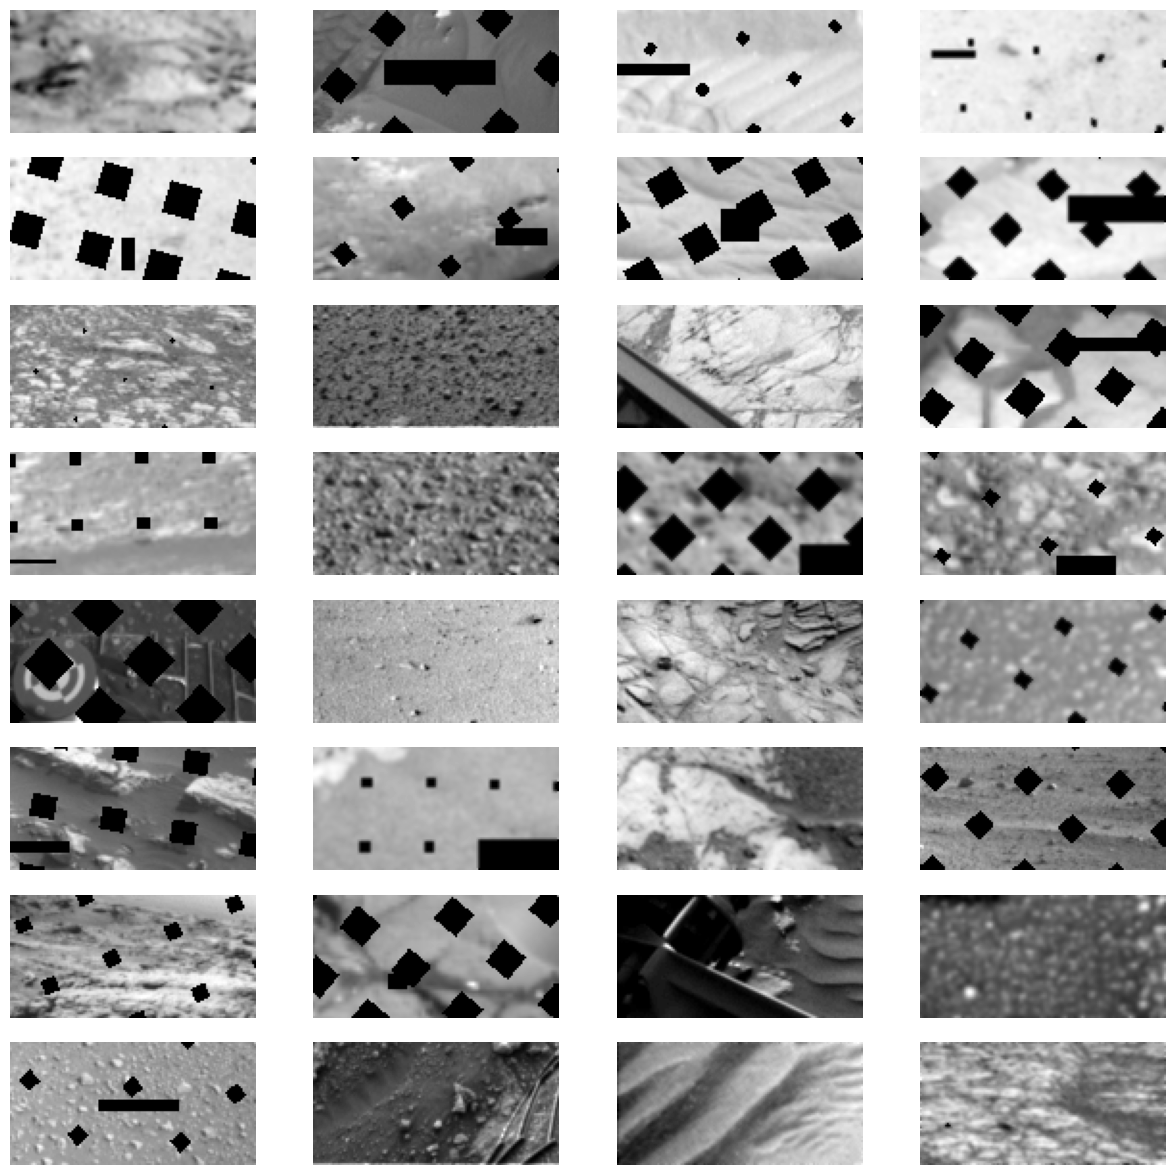

In [21]:
# Plot a batch of 32 images taken from the training dataset
plt.figure(figsize=(15, 15))
for images, labels in train_dataset.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i, :, :, 0], cmap='gray')
        plt.axis("off")
plt.show()

In [22]:
def load_single_image(image_array, label_array, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape from numpy arrays.
    """
    # Ensure the image has 1 channel
    if image_array.ndim == 2:
        image_array = np.expand_dims(image_array, axis=-1)

    # Resize the image to the fixed size
    image = tf.image.resize(image_array, input_size)
    image = tf.cast(image, tf.float32)

    # Ensure the label has a single channel
    if label_array.ndim == 2:
        label_array = np.expand_dims(label_array, axis=-1)

    # Resize the label to the fixed size
    label = tf.image.resize(label_array, input_size, method='bilinear')
    label = tf.cast(label, tf.int32)

    return image, label

In [23]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j], cmap='gray')
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

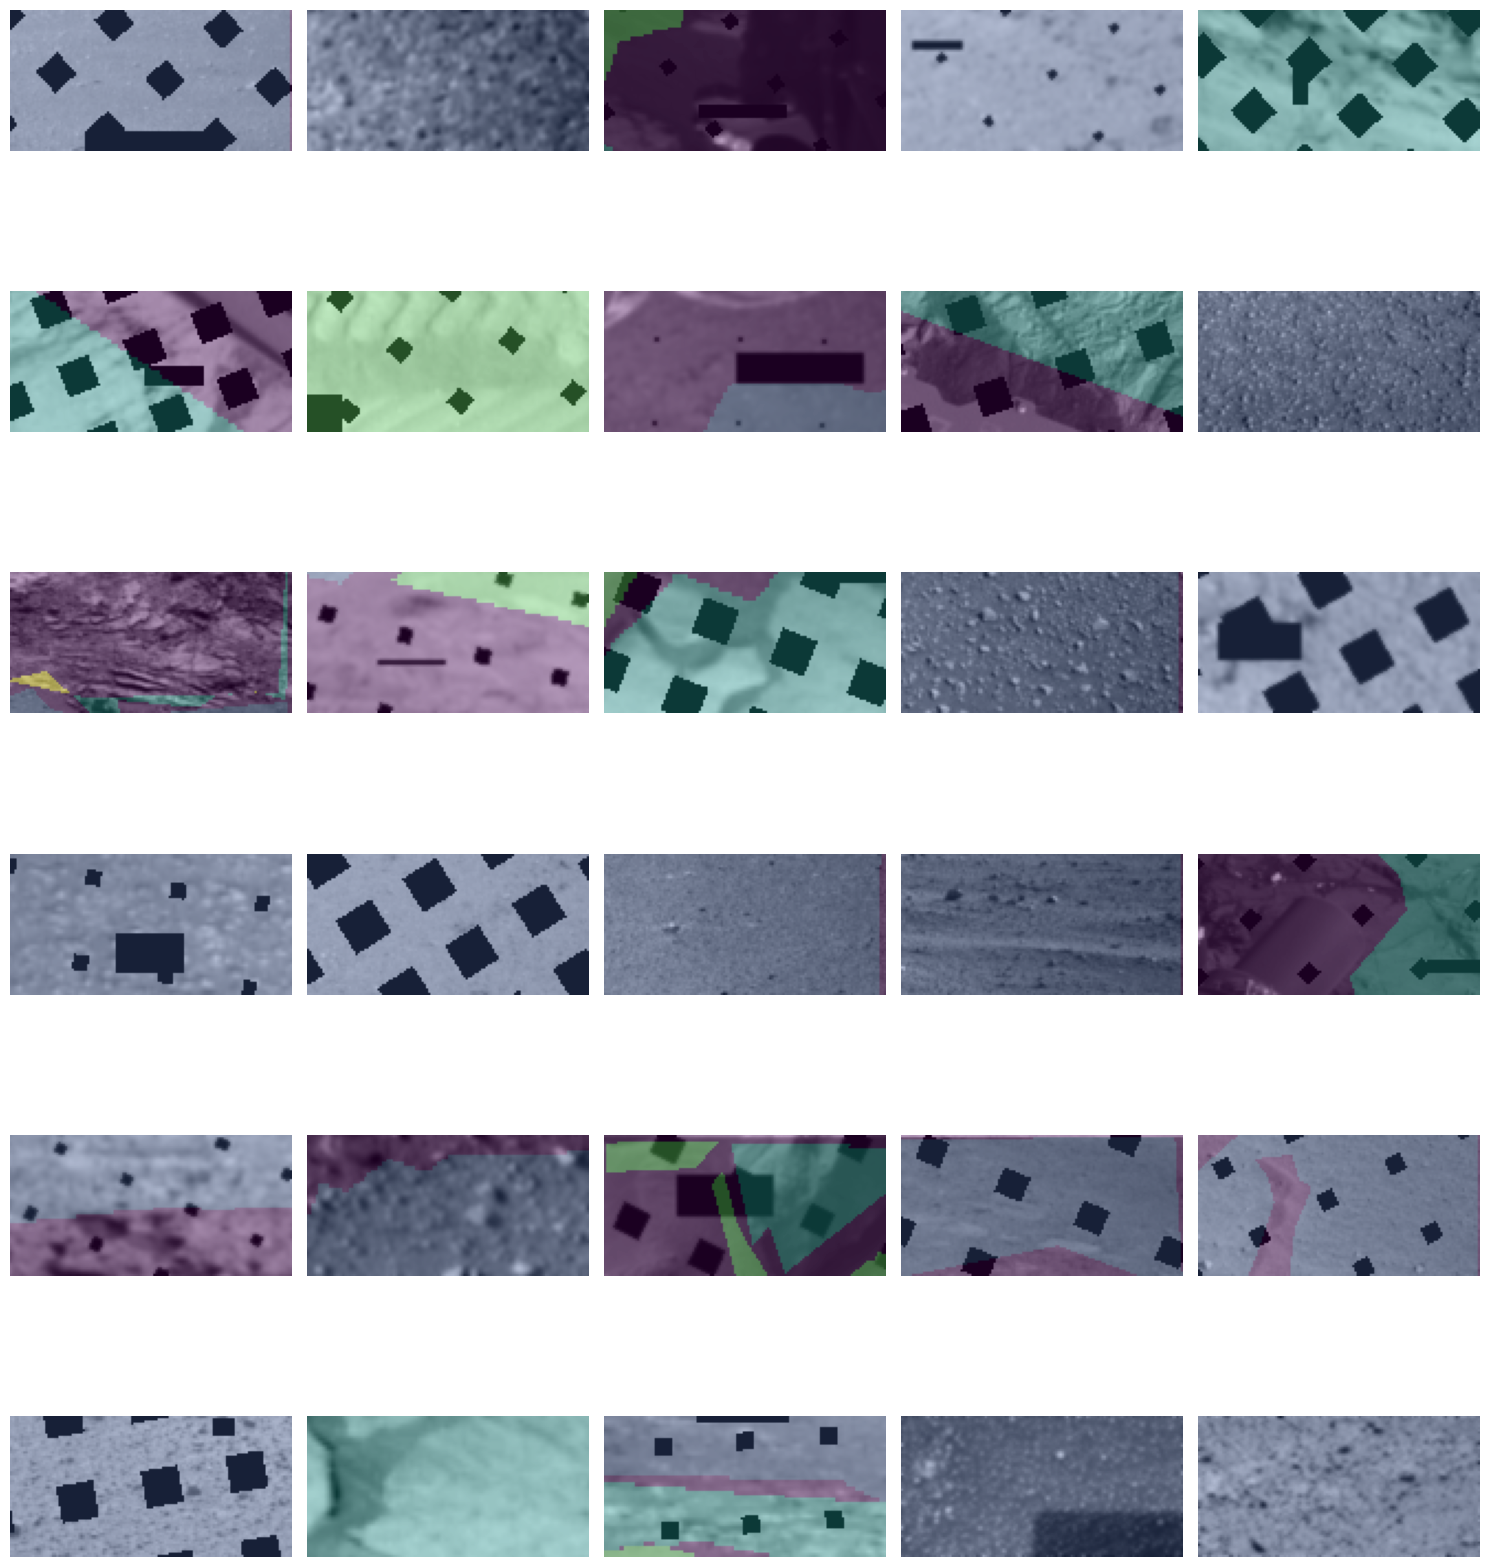

In [24]:
def plot_batch_with_labels(dataset, num_samples=30, columns=5):
    rows = num_samples // columns
    plt.figure(figsize=(15, 3 * rows))
    
    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for i in range(num_samples):
            plt.subplot(rows, columns, i + 1)
            plt.imshow(images[i], cmap='gray')
            colored_label = apply_colormap(labels_np[i], colormap)
            plt.imshow(colored_label, alpha=0.4)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot the batch with labels
plot_batch_with_labels(train_dataset)


## 🛠️ Train and Save the Model

In [25]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [26]:
!pip install focal-loss

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [27]:
# Convert class weights dictionary to a tensor
def convert_class_weights_to_tensor(class_weight_dict, num_classes):
    class_weights_list = [class_weight_dict[i] for i in range(num_classes)]
    return tf.constant(class_weights_list, dtype=tf.float32)
capped_weights_tensor = convert_class_weights_to_tensor(capped_weights, NUM_CLASSES)
class_weights_tensor = convert_class_weights_to_tensor(class_weights, NUM_CLASSES)

In [28]:
def omit_background_class_weights(class_weights_tensor, num_classes):
    # Exclude the background class (class 0) by setting its weight to 0
    weights_without_background = class_weights_tensor.numpy().tolist()
    weights_without_background[0] = 0  # Set the background class weight to 0

    # Convert back to a tensor
    return tf.constant(weights_without_background, dtype=tf.float32)

In [29]:
# Use the capped_weights_tensor or class_weights_tensor based on your preference
final_class_weights_tensor = omit_background_class_weights(capped_weights_tensor, NUM_CLASSES)

In [30]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred, smooth=1e-6, class_weights=None):
    """
    Dice Loss for segmentation tasks.
    Args:
        y_true: Ground truth tensor, one-hot encoded.
        y_pred: Predicted tensor, probabilities after softmax.
        smooth: Smoothing factor to avoid division by zero.
        class_weights: Optional weights for each class.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2))
    union = tf.reduce_sum(y_true + y_pred, axis=(1, 2))
    dice = (2. * intersection + smooth) / (union + smooth)
    
    if class_weights is not None:
        dice = dice * tf.constant(class_weights, dtype=tf.float32)
    
    return 1 - tf.reduce_mean(dice)

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    """
    Focal Loss for segmentation tasks.
    Args:
        y_true: Ground truth tensor, one-hot encoded.
        y_pred: Predicted tensor, probabilities after softmax.
        gamma: Focusing parameter to adjust difficulty weighting.
        alpha: Balance parameter for class imbalance.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())
    
    ce_loss = -y_true * tf.math.log(y_pred)
    weight = alpha * tf.math.pow(1 - y_pred, gamma)
    focal = weight * ce_loss
    return tf.reduce_mean(tf.reduce_sum(focal, axis=-1))

def boundary_loss(y_true, y_pred, boundary_weight=1.0):
    """
    Boundary Loss for precise edge predictions.
    Args:
        y_true: Ground truth tensor, binary boundary map for each class.
        y_pred: Predicted tensor, probabilities after softmax.
        boundary_weight: Weight for the boundary term.
    """
    y_true_edges = tf.image.sobel_edges(y_true)
    y_pred_edges = tf.image.sobel_edges(y_pred)
    
    edge_diff = tf.abs(y_true_edges - y_pred_edges)
    boundary_loss = boundary_weight * tf.reduce_mean(edge_diff)
    return boundary_loss


def combined_loss(y_true, y_pred, dice_weight=1.0, focal_weight=1.0, boundary_weight=1.0, class_weights=None):
    """
    Combined loss function for semantic segmentation.
    Args:
        y_true: Ground truth tensor, in integer or one-hot encoded format.
        y_pred: Predicted tensor, probabilities after softmax.
        dice_weight: Weight for the Dice Loss.
        focal_weight: Weight for the Focal Loss.
        boundary_weight: Weight for the Boundary Loss.
        class_weights: Optional weights for Dice Loss per class.
    """
    # Convert y_true to one-hot encoding
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=NUM_CLASSES)

    # Remove the extra dimension added by one-hot encoding
    try:
        y_true = tf.squeeze(y_true, axis=-2)
    except Exception:
        pass
    
    # Cast y_true to float for consistency
    y_true = tf.cast(y_true, tf.float32)

    # Exclude background class (class 0) by masking it
    mask = tf.reduce_sum(y_true[:, :, :, 1:], axis=-1, keepdims=True)
    y_true = y_true[:, :, :, 1:]  # Exclude class 0 from y_true
    y_pred = y_pred[:, :, :, 1:]  # Exclude class 0 from y_pred

    # Normalize y_pred by the mask to ensure no contribution from excluded regions
    y_pred = y_pred * mask
    
    # Compute individual loss components
    dice = dice_loss(y_true, y_pred, class_weights=class_weights[1:] if class_weights else None)
    focal = focal_loss(y_true, y_pred)
    boundary = boundary_loss(y_true, y_pred)
    
    # Combine losses
    return dice_weight * dice + focal_weight * focal + boundary_weight * boundary


Model: "U_net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 128,   │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 128,   │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 128,   │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 128,   │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 128,   │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 64,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 32,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 32,    │        256 │ conv2d_5[0][0]  

 Total params: 2,205,061 (8.41 MB)

 Trainable params: 2,202,597 (8.40 MB)

 Non-trainable params: 2,464 (9.62 KB)

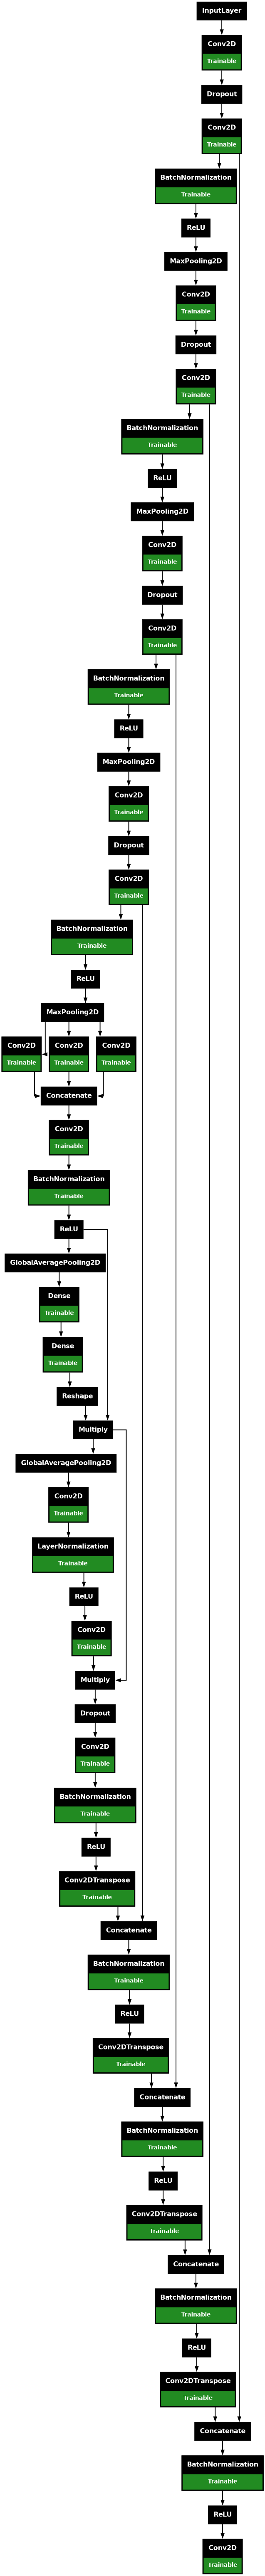

In [31]:
def squeeze_excite_block(input_tensor, reduction_ratio=16):
    """Squeeze and Excitation block"""
    channels = input_tensor.shape[-1]
    
    # Squeeze (Global Average Pooling)
    x = tfkl.GlobalAveragePooling2D()(input_tensor)
    
    # Excitation (Two Dense layers)
    x = tfkl.Dense(channels // reduction_ratio, activation='relu')(x)
    x = tfkl.Dense(channels, activation='sigmoid')(x)
    
    # Reshape to broadcasting shape
    x = tfkl.Reshape((1, 1, channels))(x)
    
    # Scale the input
    return tfkl.multiply([input_tensor, x])

def global_context_block(x, reduction_ratio=16):
    """Global context block"""
    channels = x.shape[-1]
    
    # Global context
    context = tfkl.GlobalAveragePooling2D(keepdims=True)(x)
    
    # Transform
    context = tfkl.Conv2D(channels // reduction_ratio, 1)(context)
    context = tfkl.LayerNormalization()(context)
    context = tfkl.ReLU()(context)
    context = tfkl.Conv2D(channels, 1, activation='sigmoid')(context)
    
    return tfkl.multiply([x, context])

inputs = tfkl.Input(shape=input_shape)

#Contraction path
c1 = tfkl.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tfkl.Dropout(0.1)(c1)
c1 = tfkl.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = tfkl.BatchNormalization()(c1)
r1 = tfkl.ReLU()(b1)
p1 = tfkl.MaxPooling2D((2, 2))(r1)

c2 = tfkl.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tfkl.Dropout(0.1)(c2)
c2 = tfkl.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = tfkl.BatchNormalization()(c2)
r2 = tfkl.ReLU()(b2)
p2 = tfkl.MaxPooling2D((2, 2))(r2)
 
c3 = tfkl.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tfkl.Dropout(0.2)(c3)
c3 = tfkl.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = tfkl.BatchNormalization()(c3)
r3 = tfkl.ReLU()(b3)
p3 = tfkl.MaxPooling2D((2, 2))(r3)
 
c4 = tfkl.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tfkl.Dropout(0.2)(c4)
c4 = tfkl.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = tfkl.BatchNormalization()(c4)
r4 = tfkl.ReLU()(b4)
p4 = tfkl.MaxPooling2D(pool_size=(2, 2))(r4)
 
#Bottleneck
# Parallel dilated convolutions
d1 = tfkl.Conv2D(256, (3,3), dilation_rate=1, padding='same')(p4)
d2 = tfkl.Conv2D(256, (3,3), dilation_rate=2, padding='same')(p4)
d3 = tfkl.Conv2D(256, (3,3), dilation_rate=4, padding='same')(p4)

# Concatenate dilated features
c5 = tfkl.Concatenate()([d1, d2, d3])
c5 = tfkl.Conv2D(256, (1,1))(c5)  # 1x1 conv to reduce channels

# Add batch norm and activation
c5 = tfkl.BatchNormalization()(c5)
c5 = tfkl.ReLU()(c5)

# Add squeeze-excitation
c5 = squeeze_excite_block(c5)

# Add global context
c5 = global_context_block(c5)

# Final convolutions
c5 = tfkl.Dropout(0.3)(c5)
c5 = tfkl.Conv2D(256, (3,3), padding='same')(c5)
c5 = tfkl.BatchNormalization()(c5)
c5 = tfkl.ReLU()(c5)

#Expansive path 
u6 = tfkl.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tfkl.concatenate([u6, c4])
u6 = tfkl.BatchNormalization()(u6)
u6 = tfkl.ReLU()(u6)

u7 = tfkl.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tfkl.concatenate([u7, c3])
u7 = tfkl.BatchNormalization()(u7)
u7 = tfkl.ReLU()(u7)
 
u8 = tfkl.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tfkl.concatenate([u8, c2])
u8 = tfkl.BatchNormalization()(u8)
u8 = tfkl.ReLU()(u8)
 
u9 = tfkl.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tfkl.concatenate([u9, c1], axis=3)
u9 = tfkl.BatchNormalization()(u9)
u9 = tfkl.ReLU()(u9)

outputs = tfkl.Conv2D(num_classes, (1, 1), activation='softmax')(u9)

model = tfk.Model(inputs=inputs, outputs=outputs, name="U_net")

# Define the MeanIoU ignoring the background class
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)

model.compile(
    loss=lambda y_true, y_pred: combined_loss(
                  y_true, 
                  y_pred, 
                  dice_weight=1.5, 
                  focal_weight=2.0, 
                  boundary_weight=0.5, 
                  class_weights=list(capped_weights.values())
              ),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

model.summary()
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [32]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,  
    restore_best_weights=True
)

# Reduce learning rate when the metric has stopped improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_iou',  # Use the correct name for the metric
    factor=0.35,  # Factor by which the learning rate will be reduced
    patience=25,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7  # Lower bound on the learning rate
)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image = image
        self.label = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image, self.label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))
            plt.suptitle(f"Epoch {epoch + 1}")

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

vizcallback = VizCallback(image=val_img[0], label=val_lbl[0], frequency=5)

Epoch 1/500


I0000 00:00:1733661484.047346      76 service.cc:145] XLA service 0x785094001570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733661484.047443      76 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 5/60 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2291 - loss: 1.8674 - mean_iou: 0.0918

I0000 00:00:1733661503.192514      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.2748 - loss: 1.6004 - mean_iou: 0.1251

I0000 00:00:1733661521.417558      76 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_3', 16 bytes spill stores, 16 bytes spill loads



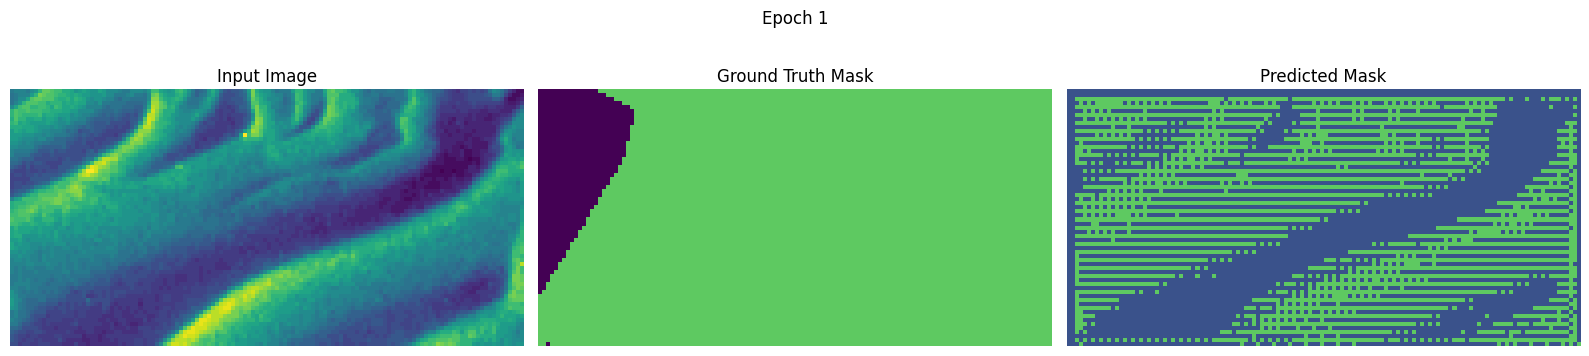

60/60 ━━━━━━━━━━━━━━━━━━━━ 57s 475ms/step - accuracy: 0.2755 - loss: 1.5985 - mean_iou: 0.1255 - val_accuracy: 0.2807 - val_loss: 1.6284 - val_mean_iou: 0.1089 - learning_rate: 0.0010
Epoch 2/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3971 - loss: 1.4004 - mean_iou: 0.1752 - val_accuracy: 0.3072 - val_loss: 1.5674 - val_mean_iou: 0.1755 - learning_rate: 0.0010
Epoch 3/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.4186 - loss: 1.3348 - mean_iou: 0.2190 - val_accuracy: 0.3124 - val_loss: 1.5255 - val_mean_iou: 0.1880 - learning_rate: 0.0010
Epoch 4/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.4254 - loss: 1.2987 - mean_iou: 0.2322 - val_accuracy: 0.3404 - val_loss: 1.5278 - val_mean_iou: 0.2108 - learning_rate: 0.0010
Epoch 5/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.4597 - loss: 1.3020 - mean_iou: 0.2559 - val_accuracy: 0.2677 - val_loss: 1.6195 - val_mean_iou: 0.1436 - learning_rate: 0.0010
Epoch 6/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0

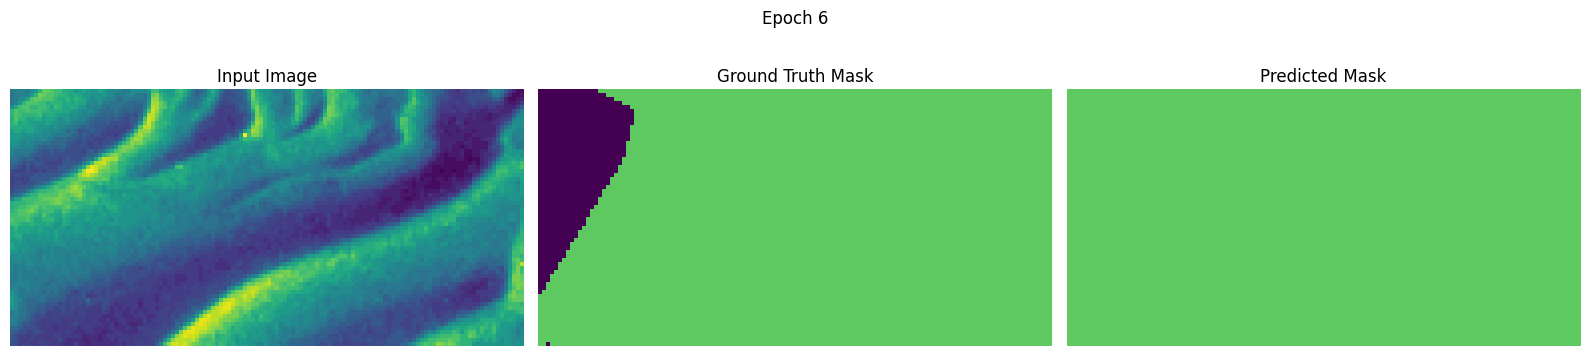

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.4712 - loss: 1.3012 - mean_iou: 0.3312 - val_accuracy: 0.4326 - val_loss: 1.4330 - val_mean_iou: 0.2939 - learning_rate: 0.0010
Epoch 7/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.4979 - loss: 1.2371 - mean_iou: 0.3605 - val_accuracy: 0.3998 - val_loss: 1.4712 - val_mean_iou: 0.2548 - learning_rate: 0.0010
Epoch 8/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5074 - loss: 1.2127 - mean_iou: 0.3673 - val_accuracy: 0.4682 - val_loss: 1.4075 - val_mean_iou: 0.3307 - learning_rate: 0.0010
Epoch 9/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5230 - loss: 1.2287 - mean_iou: 0.3810 - val_accuracy: 0.4893 - val_loss: 1.4292 - val_mean_iou: 0.3477 - learning_rate: 0.0010
Epoch 10/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5313 - loss: 1.2599 - mean_iou: 0.3945 - val_accuracy: 0.5183 - val_loss: 1.3997 - val_mean_iou: 0.3765 - learning_rate: 0.0010
Epoch 11/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0

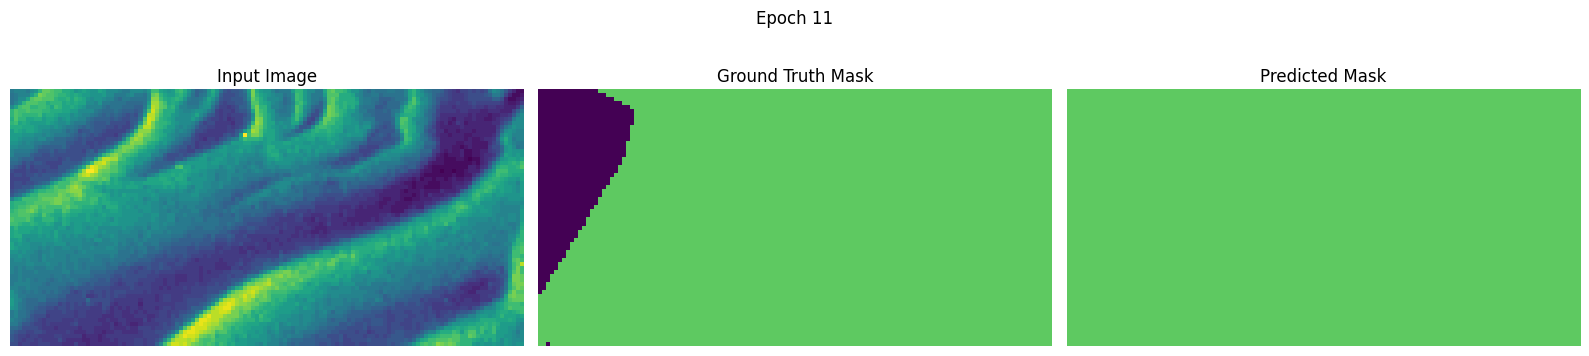

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.5232 - loss: 1.2232 - mean_iou: 0.3915 - val_accuracy: 0.5487 - val_loss: 1.3584 - val_mean_iou: 0.4255 - learning_rate: 0.0010
Epoch 12/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5505 - loss: 1.2167 - mean_iou: 0.4207 - val_accuracy: 0.5133 - val_loss: 1.4079 - val_mean_iou: 0.3786 - learning_rate: 0.0010
Epoch 13/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5641 - loss: 1.1549 - mean_iou: 0.4345 - val_accuracy: 0.5130 - val_loss: 1.3706 - val_mean_iou: 0.3795 - learning_rate: 0.0010
Epoch 14/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.5634 - loss: 1.1792 - mean_iou: 0.4353 - val_accuracy: 0.3678 - val_loss: 1.5916 - val_mean_iou: 0.2299 - learning_rate: 0.0010
Epoch 15/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5729 - loss: 1.1522 - mean_iou: 0.4511 - val_accuracy: 0.5557 - val_loss: 1.3631 - val_mean_iou: 0.4269 - learning_rate: 0.0010
Epoch 16/500
59/60 ━━━━━━━━━━━━━━━━━━━

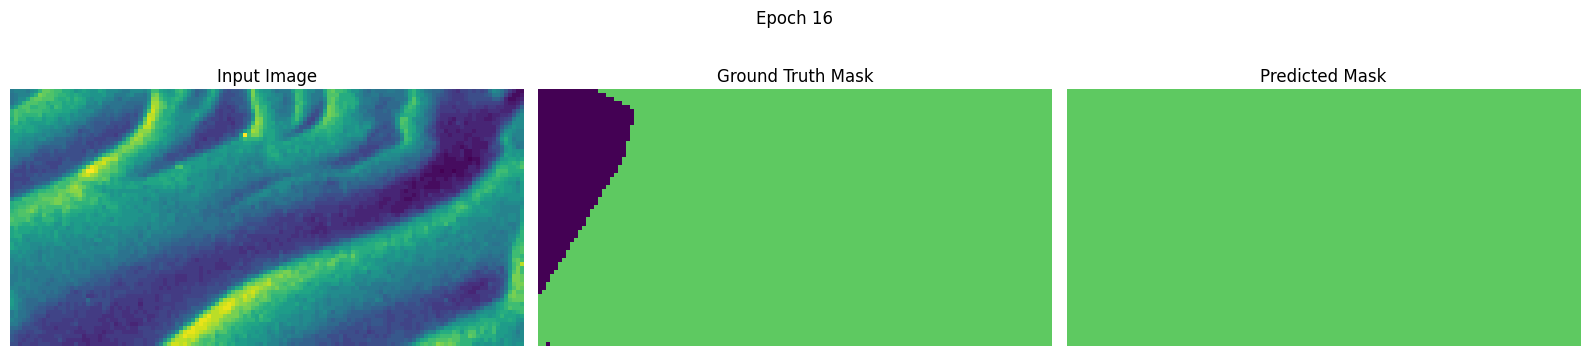

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.5745 - loss: 1.1971 - mean_iou: 0.4467 - val_accuracy: 0.5731 - val_loss: 1.3415 - val_mean_iou: 0.4425 - learning_rate: 0.0010
Epoch 17/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5941 - loss: 1.2127 - mean_iou: 0.4718 - val_accuracy: 0.6031 - val_loss: 1.3183 - val_mean_iou: 0.4828 - learning_rate: 0.0010
Epoch 18/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5859 - loss: 1.1749 - mean_iou: 0.4605 - val_accuracy: 0.5257 - val_loss: 1.4205 - val_mean_iou: 0.3790 - learning_rate: 0.0010
Epoch 19/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5922 - loss: 1.2062 - mean_iou: 0.4690 - val_accuracy: 0.5563 - val_loss: 1.3462 - val_mean_iou: 0.4250 - learning_rate: 0.0010
Epoch 20/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5997 - loss: 1.1545 - mean_iou: 0.4776 - val_accuracy: 0.6028 - val_loss: 1.3226 - val_mean_iou: 0.4807 - learning_rate: 0.0010
Epoch 21/500
60/60 ━━━━━━━━━━━━━━━━━━━

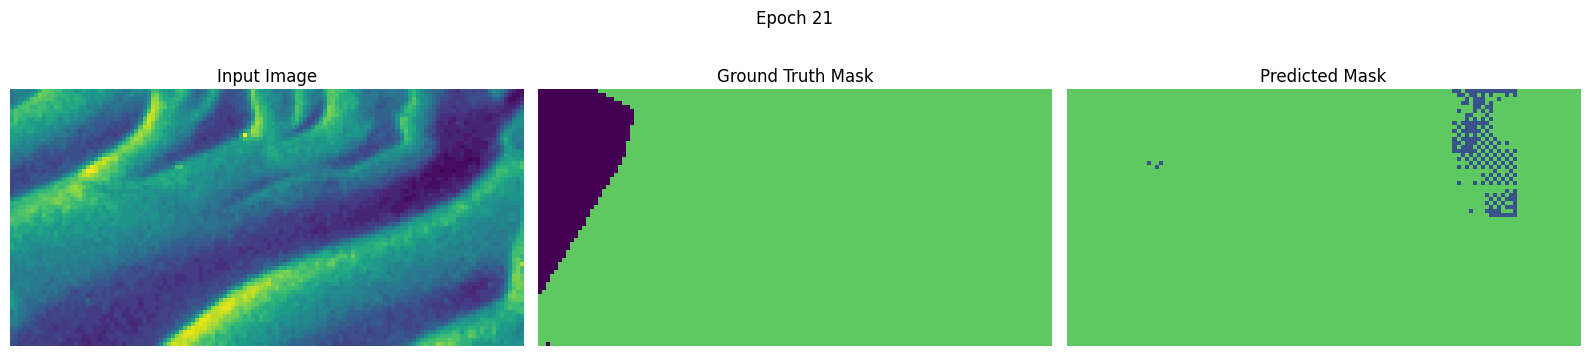

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6106 - loss: 1.1228 - mean_iou: 0.4909 - val_accuracy: 0.5937 - val_loss: 1.3313 - val_mean_iou: 0.4783 - learning_rate: 0.0010
Epoch 22/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6018 - loss: 1.1523 - mean_iou: 0.4918 - val_accuracy: 0.6116 - val_loss: 1.3047 - val_mean_iou: 0.4934 - learning_rate: 0.0010
Epoch 23/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6265 - loss: 1.1230 - mean_iou: 0.5131 - val_accuracy: 0.5607 - val_loss: 1.3566 - val_mean_iou: 0.4292 - learning_rate: 0.0010
Epoch 24/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6209 - loss: 1.1436 - mean_iou: 0.5034 - val_accuracy: 0.5906 - val_loss: 1.3385 - val_mean_iou: 0.4692 - learning_rate: 0.0010
Epoch 25/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6227 - loss: 1.1539 - mean_iou: 0.5052 - val_accuracy: 0.5989 - val_loss: 1.3259 - val_mean_iou: 0.4774 - learning_rate: 0.0010
Epoch 26/500
59/60 ━━━━━━━━━━━━━━━━━━━

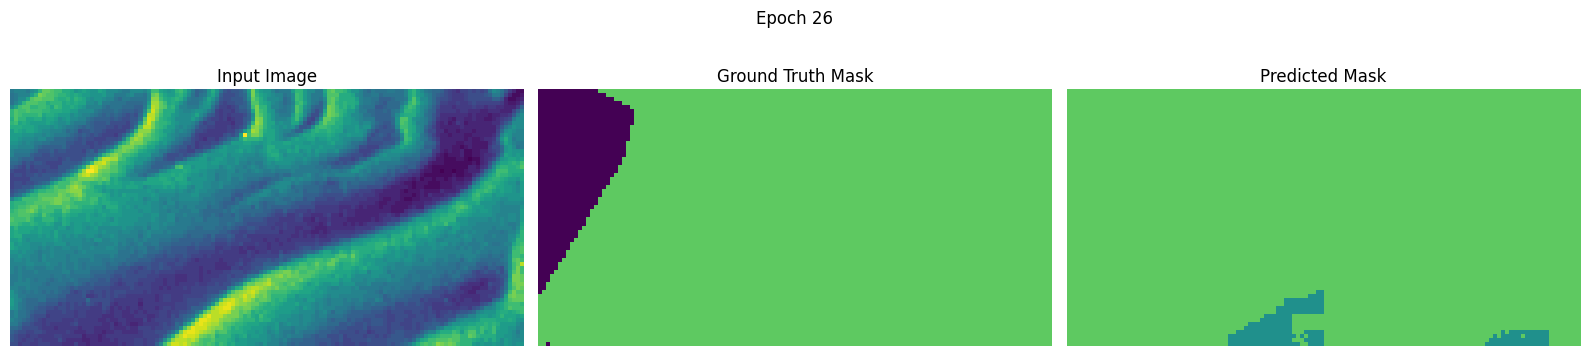

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6283 - loss: 1.1480 - mean_iou: 0.5147 - val_accuracy: 0.5828 - val_loss: 1.3442 - val_mean_iou: 0.4610 - learning_rate: 0.0010
Epoch 27/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6170 - loss: 1.1303 - mean_iou: 0.4999 - val_accuracy: 0.6222 - val_loss: 1.2830 - val_mean_iou: 0.5092 - learning_rate: 3.5000e-04
Epoch 28/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6366 - loss: 1.1081 - mean_iou: 0.5304 - val_accuracy: 0.6491 - val_loss: 1.2594 - val_mean_iou: 0.5474 - learning_rate: 3.5000e-04
Epoch 29/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6405 - loss: 1.0770 - mean_iou: 0.5414 - val_accuracy: 0.6576 - val_loss: 1.2589 - val_mean_iou: 0.5573 - learning_rate: 3.5000e-04
Epoch 30/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6353 - loss: 1.1025 - mean_iou: 0.5308 - val_accuracy: 0.6433 - val_loss: 1.2680 - val_mean_iou: 0.5402 - learning_rate: 3.5000e-04
Epoch 31/500
59/60 ━━━

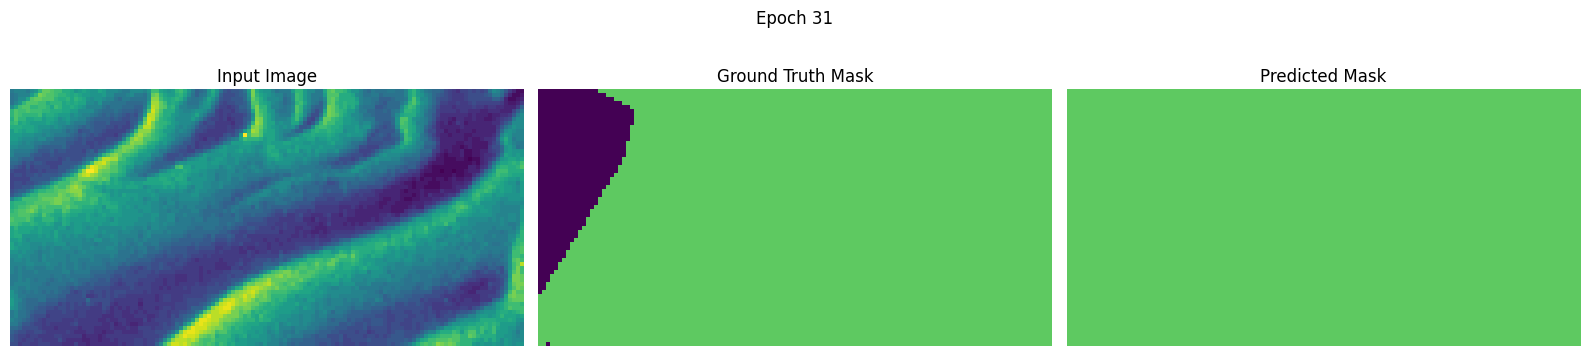

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6433 - loss: 1.0939 - mean_iou: 0.5494 - val_accuracy: 0.6497 - val_loss: 1.2548 - val_mean_iou: 0.5475 - learning_rate: 3.5000e-04
Epoch 32/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6525 - loss: 1.0859 - mean_iou: 0.5572 - val_accuracy: 0.6547 - val_loss: 1.2635 - val_mean_iou: 0.5539 - learning_rate: 3.5000e-04
Epoch 33/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6648 - loss: 1.1206 - mean_iou: 0.5687 - val_accuracy: 0.6489 - val_loss: 1.2666 - val_mean_iou: 0.5433 - learning_rate: 3.5000e-04
Epoch 34/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6490 - loss: 1.0913 - mean_iou: 0.5586 - val_accuracy: 0.6542 - val_loss: 1.2598 - val_mean_iou: 0.5547 - learning_rate: 3.5000e-04
Epoch 35/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6493 - loss: 1.0960 - mean_iou: 0.5582 - val_accuracy: 0.6527 - val_loss: 1.2700 - val_mean_iou: 0.5512 - learning_rate: 3.5000e-04
Epoch 36/500
60/60

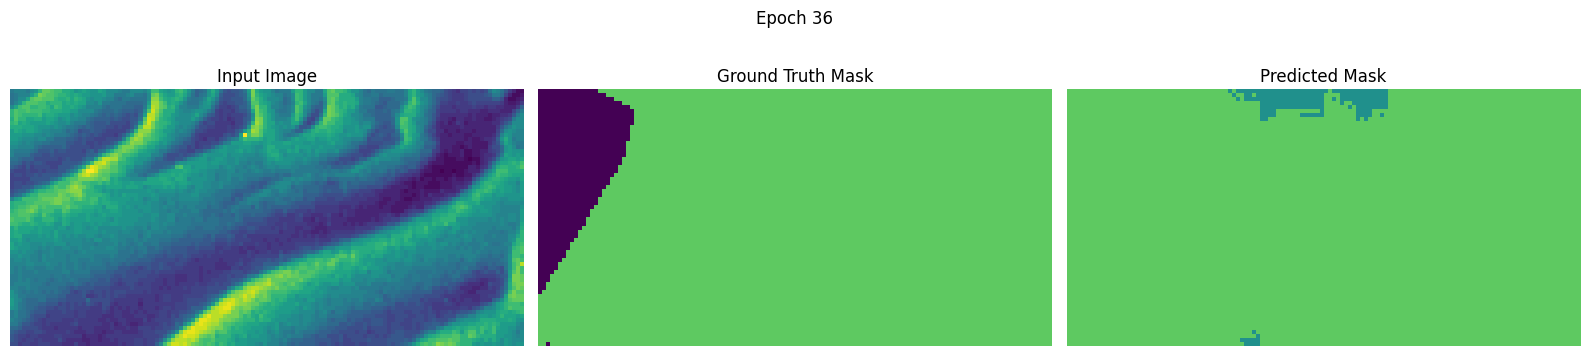

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6487 - loss: 1.1196 - mean_iou: 0.5546 - val_accuracy: 0.6425 - val_loss: 1.2745 - val_mean_iou: 0.5407 - learning_rate: 3.5000e-04
Epoch 37/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6611 - loss: 1.0968 - mean_iou: 0.5860 - val_accuracy: 0.6367 - val_loss: 1.2871 - val_mean_iou: 0.5292 - learning_rate: 3.5000e-04
Epoch 38/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6617 - loss: 1.0778 - mean_iou: 0.5805 - val_accuracy: 0.6475 - val_loss: 1.2762 - val_mean_iou: 0.5457 - learning_rate: 3.5000e-04
Epoch 39/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6525 - loss: 1.0832 - mean_iou: 0.5654 - val_accuracy: 0.6472 - val_loss: 1.2679 - val_mean_iou: 0.5489 - learning_rate: 3.5000e-04
Epoch 40/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6717 - loss: 1.0844 - mean_iou: 0.5899 - val_accuracy: 0.6490 - val_loss: 1.2597 - val_mean_iou: 0.5523 - learning_rate: 3.5000e-04
Epoch 41/500
60/60

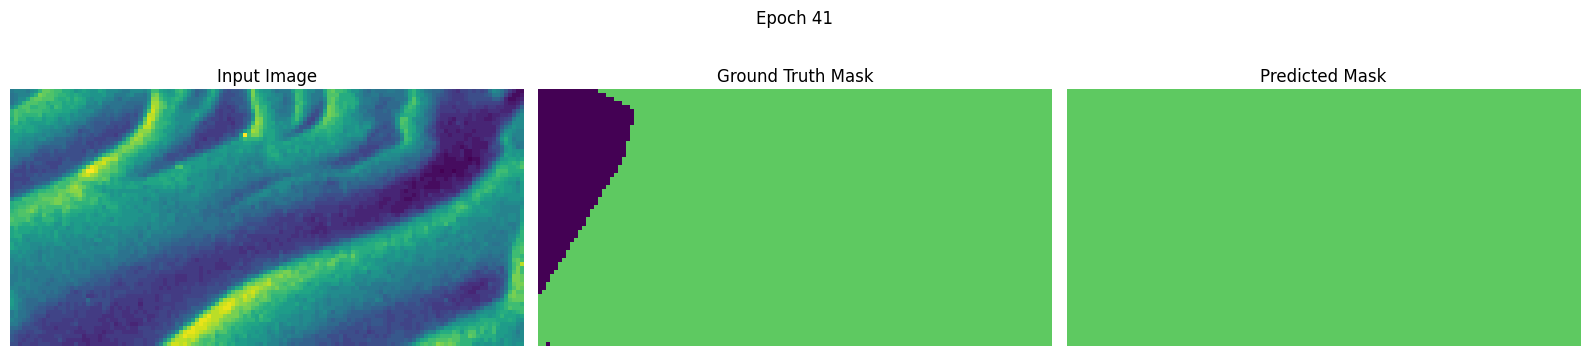

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6586 - loss: 1.1130 - mean_iou: 0.5842 - val_accuracy: 0.6361 - val_loss: 1.2773 - val_mean_iou: 0.5336 - learning_rate: 3.5000e-04
Epoch 42/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6563 - loss: 1.0993 - mean_iou: 0.5799 - val_accuracy: 0.6583 - val_loss: 1.2623 - val_mean_iou: 0.5653 - learning_rate: 3.5000e-04
Epoch 43/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6746 - loss: 1.0813 - mean_iou: 0.5913 - val_accuracy: 0.6498 - val_loss: 1.2660 - val_mean_iou: 0.5532 - learning_rate: 3.5000e-04
Epoch 44/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6641 - loss: 1.0914 - mean_iou: 0.5922 - val_accuracy: 0.6533 - val_loss: 1.2656 - val_mean_iou: 0.5539 - learning_rate: 3.5000e-04
Epoch 45/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6618 - loss: 1.0974 - mean_iou: 0.5830 - val_accuracy: 0.6495 - val_loss: 1.2618 - val_mean_iou: 0.5501 - learning_rate: 3.5000e-04
Epoch 46/500
60/60

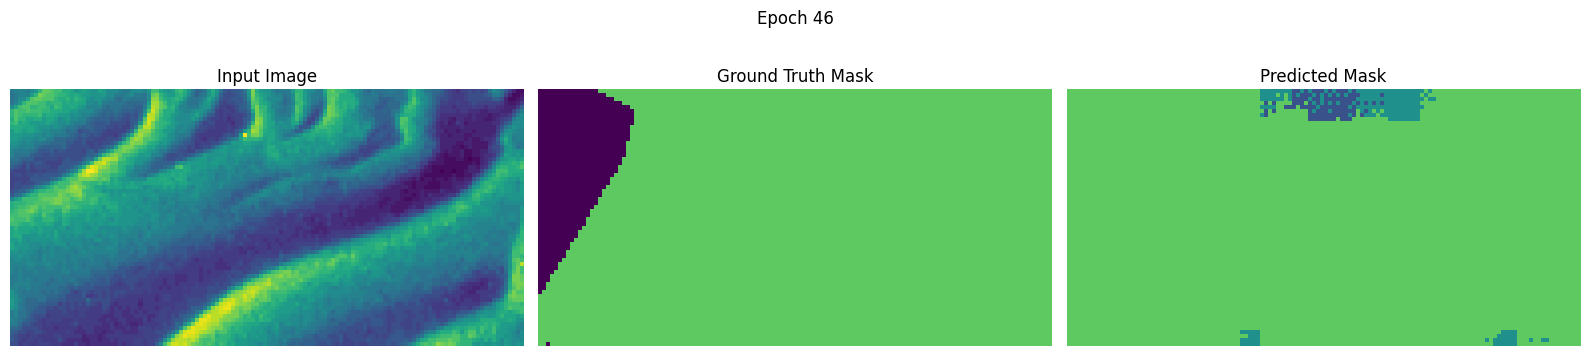

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6654 - loss: 1.0536 - mean_iou: 0.5939 - val_accuracy: 0.6502 - val_loss: 1.2687 - val_mean_iou: 0.5558 - learning_rate: 3.5000e-04
Epoch 47/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6659 - loss: 1.0813 - mean_iou: 0.5929 - val_accuracy: 0.6608 - val_loss: 1.2502 - val_mean_iou: 0.5708 - learning_rate: 3.5000e-04
Epoch 48/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6680 - loss: 1.1076 - mean_iou: 0.5924 - val_accuracy: 0.6617 - val_loss: 1.2507 - val_mean_iou: 0.5753 - learning_rate: 3.5000e-04
Epoch 49/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6700 - loss: 1.0780 - mean_iou: 0.6115 - val_accuracy: 0.6399 - val_loss: 1.2668 - val_mean_iou: 0.5433 - learning_rate: 3.5000e-04
Epoch 50/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6656 - loss: 1.0855 - mean_iou: 0.5959 - val_accuracy: 0.6400 - val_loss: 1.2766 - val_mean_iou: 0.5364 - learning_rate: 3.5000e-04
Epoch 51/500
59/60

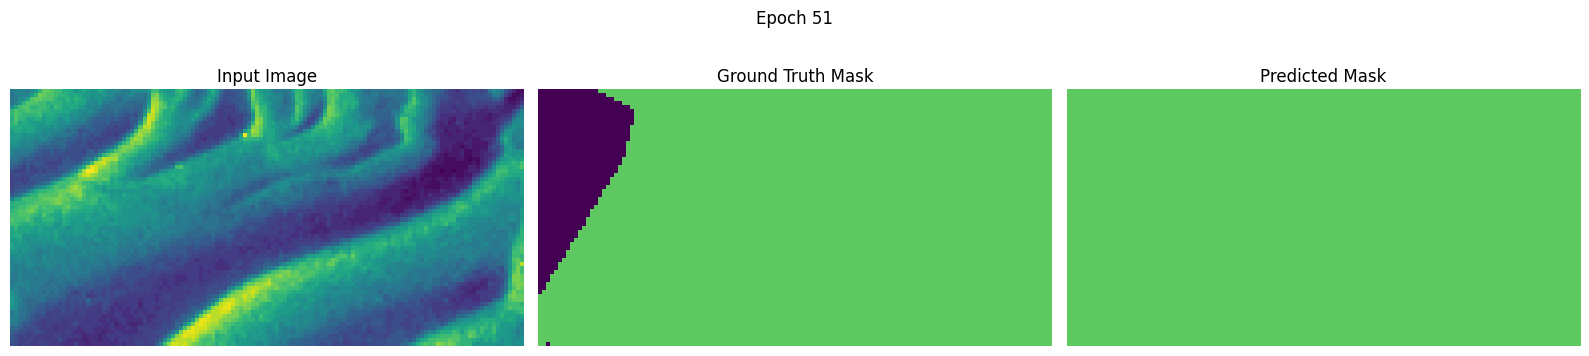

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6652 - loss: 1.0575 - mean_iou: 0.6021 - val_accuracy: 0.6464 - val_loss: 1.2682 - val_mean_iou: 0.5435 - learning_rate: 3.5000e-04
Epoch 52/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6841 - loss: 1.0492 - mean_iou: 0.6392 - val_accuracy: 0.6674 - val_loss: 1.2462 - val_mean_iou: 0.5761 - learning_rate: 1.2250e-04
Epoch 53/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6654 - loss: 1.0727 - mean_iou: 0.6004 - val_accuracy: 0.6697 - val_loss: 1.2462 - val_mean_iou: 0.5802 - learning_rate: 1.2250e-04
Epoch 54/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.6739 - loss: 1.0414 - mean_iou: 0.6156 - val_accuracy: 0.6603 - val_loss: 1.2478 - val_mean_iou: 0.5645 - learning_rate: 1.2250e-04
Epoch 55/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6802 - loss: 1.0559 - mean_iou: 0.6302 - val_accuracy: 0.6662 - val_loss: 1.2467 - val_mean_iou: 0.5743 - learning_rate: 1.2250e-04
Epoch 56/500
60/60

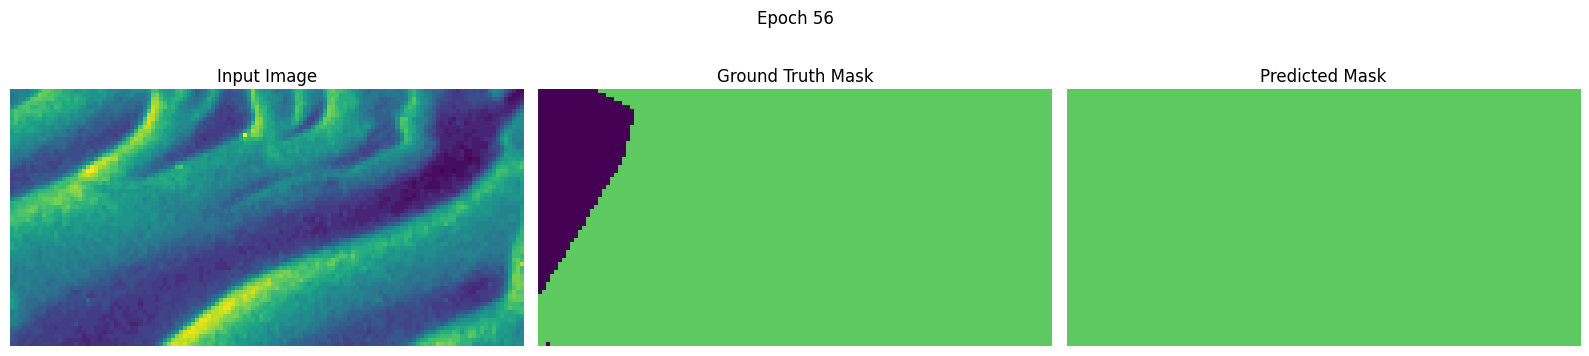

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6772 - loss: 1.0321 - mean_iou: 0.6213 - val_accuracy: 0.6688 - val_loss: 1.2419 - val_mean_iou: 0.5776 - learning_rate: 1.2250e-04
Epoch 57/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6804 - loss: 1.0673 - mean_iou: 0.6224 - val_accuracy: 0.6413 - val_loss: 1.2627 - val_mean_iou: 0.5377 - learning_rate: 1.2250e-04
Epoch 58/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6772 - loss: 1.0776 - mean_iou: 0.6206 - val_accuracy: 0.6689 - val_loss: 1.2356 - val_mean_iou: 0.5799 - learning_rate: 1.2250e-04
Epoch 59/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6781 - loss: 1.0996 - mean_iou: 0.6378 - val_accuracy: 0.6701 - val_loss: 1.2386 - val_mean_iou: 0.5796 - learning_rate: 1.2250e-04
Epoch 60/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6638 - loss: 1.0592 - mean_iou: 0.6194 - val_accuracy: 0.6612 - val_loss: 1.2457 - val_mean_iou: 0.5658 - learning_rate: 1.2250e-04
Epoch 61/500
60/60

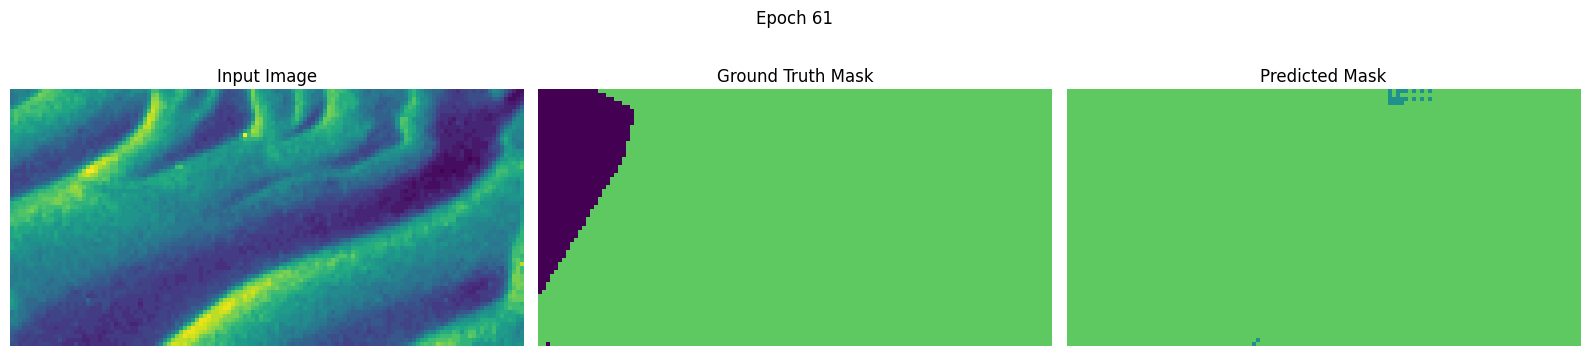

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6723 - loss: 1.0284 - mean_iou: 0.6222 - val_accuracy: 0.6610 - val_loss: 1.2418 - val_mean_iou: 0.5651 - learning_rate: 1.2250e-04
Epoch 62/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6739 - loss: 1.0644 - mean_iou: 0.6171 - val_accuracy: 0.6649 - val_loss: 1.2456 - val_mean_iou: 0.5745 - learning_rate: 1.2250e-04
Epoch 63/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6905 - loss: 1.0773 - mean_iou: 0.6358 - val_accuracy: 0.6665 - val_loss: 1.2471 - val_mean_iou: 0.5743 - learning_rate: 1.2250e-04
Epoch 64/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6774 - loss: 1.0193 - mean_iou: 0.6371 - val_accuracy: 0.6701 - val_loss: 1.2408 - val_mean_iou: 0.5807 - learning_rate: 1.2250e-04
Epoch 65/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6900 - loss: 1.0271 - mean_iou: 0.6427 - val_accuracy: 0.6648 - val_loss: 1.2497 - val_mean_iou: 0.5726 - learning_rate: 1.2250e-04
Epoch 66/500
60/60

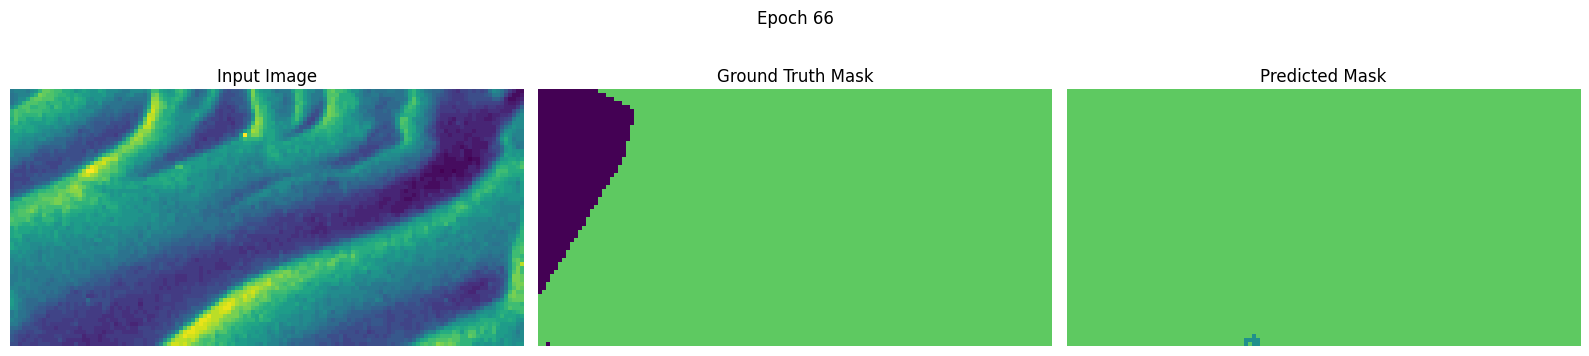

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6874 - loss: 1.0256 - mean_iou: 0.6432 - val_accuracy: 0.6557 - val_loss: 1.2451 - val_mean_iou: 0.5645 - learning_rate: 1.2250e-04
Epoch 67/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6851 - loss: 1.0714 - mean_iou: 0.6350 - val_accuracy: 0.6613 - val_loss: 1.2404 - val_mean_iou: 0.5667 - learning_rate: 1.2250e-04
Epoch 68/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6833 - loss: 1.0571 - mean_iou: 0.6458 - val_accuracy: 0.6472 - val_loss: 1.2614 - val_mean_iou: 0.5445 - learning_rate: 1.2250e-04
Epoch 69/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6851 - loss: 1.0755 - mean_iou: 0.6280 - val_accuracy: 0.6692 - val_loss: 1.2414 - val_mean_iou: 0.5801 - learning_rate: 1.2250e-04
Epoch 70/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6741 - loss: 1.0219 - mean_iou: 0.6186 - val_accuracy: 0.6738 - val_loss: 1.2385 - val_mean_iou: 0.5871 - learning_rate: 1.2250e-04
Epoch 71/500
60/60

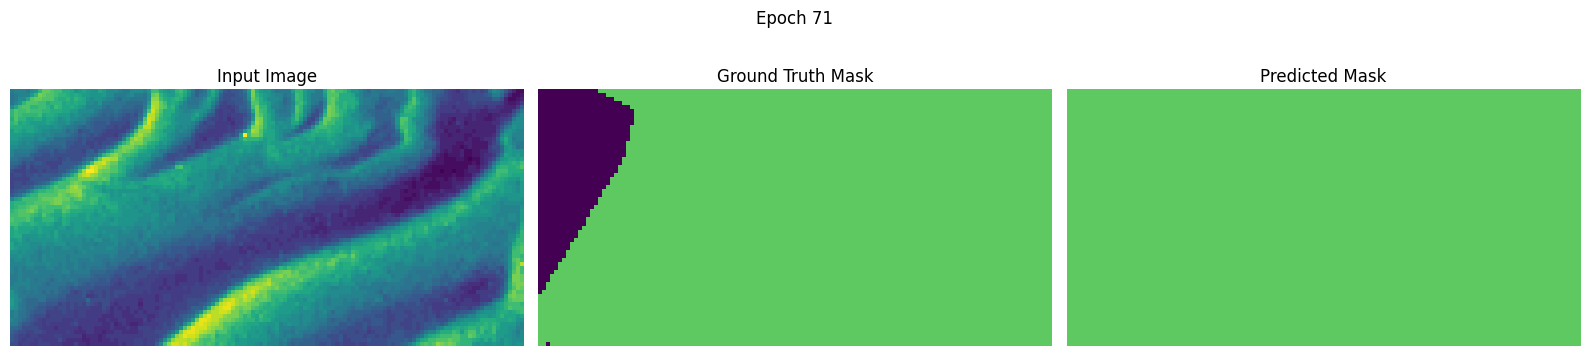

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6903 - loss: 1.0423 - mean_iou: 0.6373 - val_accuracy: 0.6704 - val_loss: 1.2445 - val_mean_iou: 0.5803 - learning_rate: 1.2250e-04
Epoch 72/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6865 - loss: 1.0561 - mean_iou: 0.6449 - val_accuracy: 0.6606 - val_loss: 1.2436 - val_mean_iou: 0.5647 - learning_rate: 1.2250e-04
Epoch 73/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6860 - loss: 1.0506 - mean_iou: 0.6311 - val_accuracy: 0.6710 - val_loss: 1.2406 - val_mean_iou: 0.5814 - learning_rate: 1.2250e-04
Epoch 74/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6760 - loss: 1.0286 - mean_iou: 0.6210 - val_accuracy: 0.6744 - val_loss: 1.2393 - val_mean_iou: 0.5861 - learning_rate: 1.2250e-04
Epoch 75/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6834 - loss: 1.0604 - mean_iou: 0.6434 - val_accuracy: 0.6775 - val_loss: 1.2355 - val_mean_iou: 0.5906 - learning_rate: 1.2250e-04
Epoch 76/500
59/60

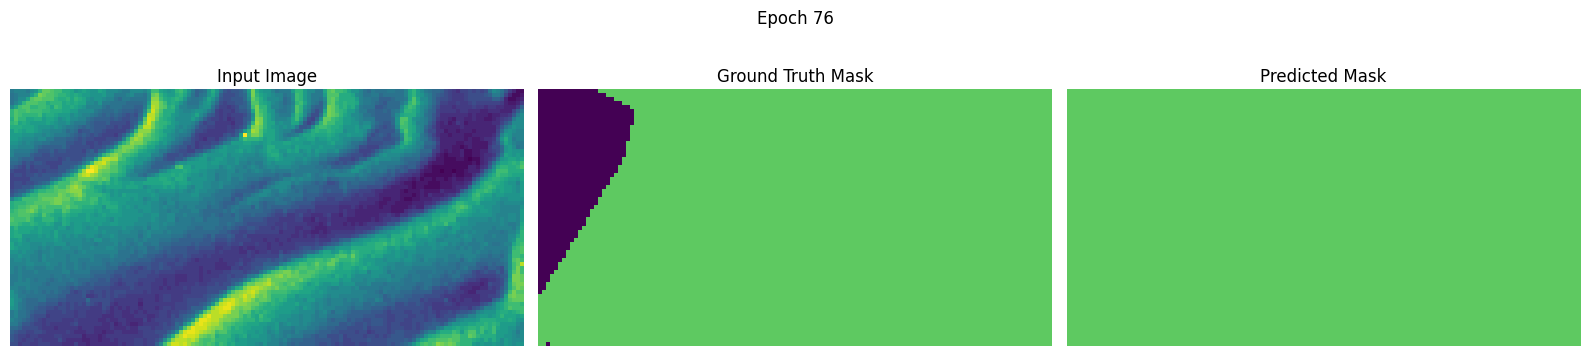

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6922 - loss: 1.0793 - mean_iou: 0.6497 - val_accuracy: 0.6548 - val_loss: 1.2548 - val_mean_iou: 0.5582 - learning_rate: 1.2250e-04
Epoch 77/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6944 - loss: 1.0247 - mean_iou: 0.6660 - val_accuracy: 0.6636 - val_loss: 1.2432 - val_mean_iou: 0.5707 - learning_rate: 4.2875e-05
Epoch 78/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6877 - loss: 1.0549 - mean_iou: 0.6468 - val_accuracy: 0.6716 - val_loss: 1.2374 - val_mean_iou: 0.5820 - learning_rate: 4.2875e-05
Epoch 79/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6919 - loss: 1.0271 - mean_iou: 0.6586 - val_accuracy: 0.6711 - val_loss: 1.2377 - val_mean_iou: 0.5812 - learning_rate: 4.2875e-05
Epoch 80/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6932 - loss: 1.0381 - mean_iou: 0.6607 - val_accuracy: 0.6751 - val_loss: 1.2354 - val_mean_iou: 0.5880 - learning_rate: 4.2875e-05
Epoch 81/500
60/60

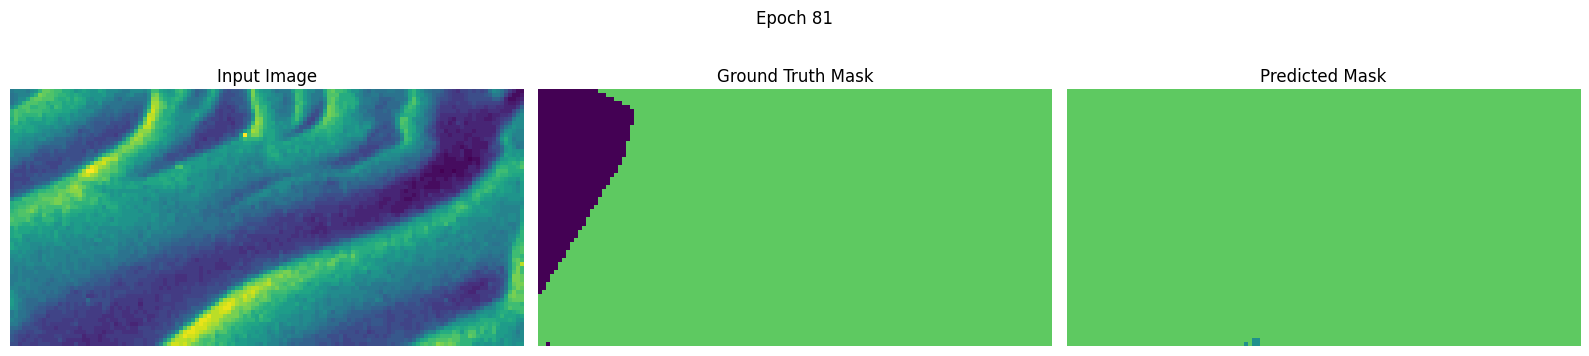

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6875 - loss: 1.0447 - mean_iou: 0.6420 - val_accuracy: 0.6675 - val_loss: 1.2384 - val_mean_iou: 0.5758 - learning_rate: 4.2875e-05
Epoch 82/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6896 - loss: 0.9970 - mean_iou: 0.6544 - val_accuracy: 0.6720 - val_loss: 1.2391 - val_mean_iou: 0.5826 - learning_rate: 4.2875e-05
Epoch 83/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6850 - loss: 1.0051 - mean_iou: 0.6468 - val_accuracy: 0.6713 - val_loss: 1.2393 - val_mean_iou: 0.5810 - learning_rate: 4.2875e-05
Epoch 84/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6901 - loss: 1.0594 - mean_iou: 0.6520 - val_accuracy: 0.6738 - val_loss: 1.2375 - val_mean_iou: 0.5854 - learning_rate: 4.2875e-05
Epoch 85/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6831 - loss: 1.0320 - mean_iou: 0.6385 - val_accuracy: 0.6731 - val_loss: 1.2394 - val_mean_iou: 0.5839 - learning_rate: 4.2875e-05
Epoch 86/500
60/60

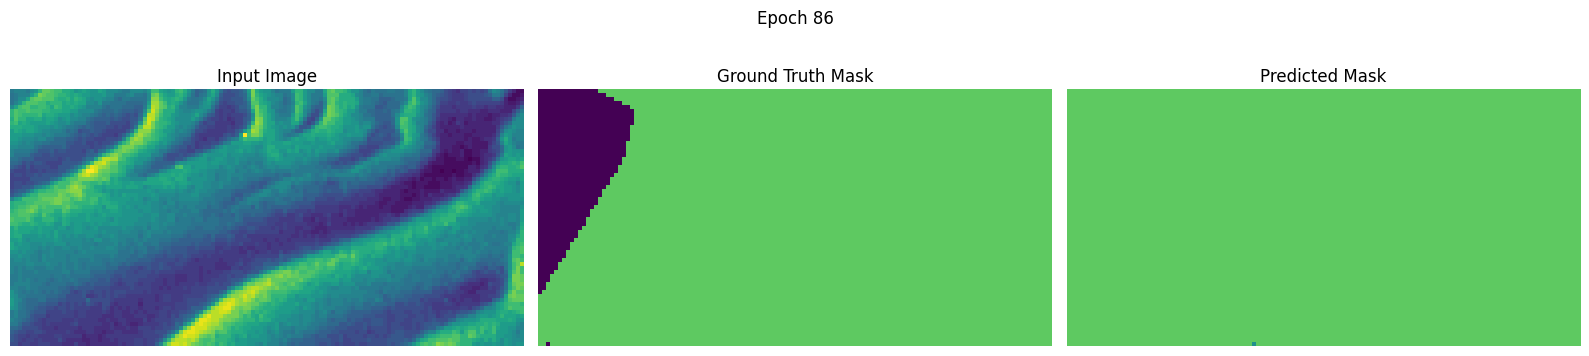

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6853 - loss: 1.0133 - mean_iou: 0.6404 - val_accuracy: 0.6738 - val_loss: 1.2356 - val_mean_iou: 0.5857 - learning_rate: 4.2875e-05
Epoch 87/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6952 - loss: 1.0258 - mean_iou: 0.6741 - val_accuracy: 0.6742 - val_loss: 1.2337 - val_mean_iou: 0.5866 - learning_rate: 4.2875e-05
Epoch 88/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6809 - loss: 1.0063 - mean_iou: 0.6503 - val_accuracy: 0.6753 - val_loss: 1.2352 - val_mean_iou: 0.5886 - learning_rate: 4.2875e-05
Epoch 89/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6840 - loss: 1.0187 - mean_iou: 0.6467 - val_accuracy: 0.6691 - val_loss: 1.2414 - val_mean_iou: 0.5778 - learning_rate: 4.2875e-05
Epoch 90/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6878 - loss: 1.0441 - mean_iou: 0.6371 - val_accuracy: 0.6736 - val_loss: 1.2413 - val_mean_iou: 0.5844 - learning_rate: 4.2875e-05
Epoch 91/500
59/60

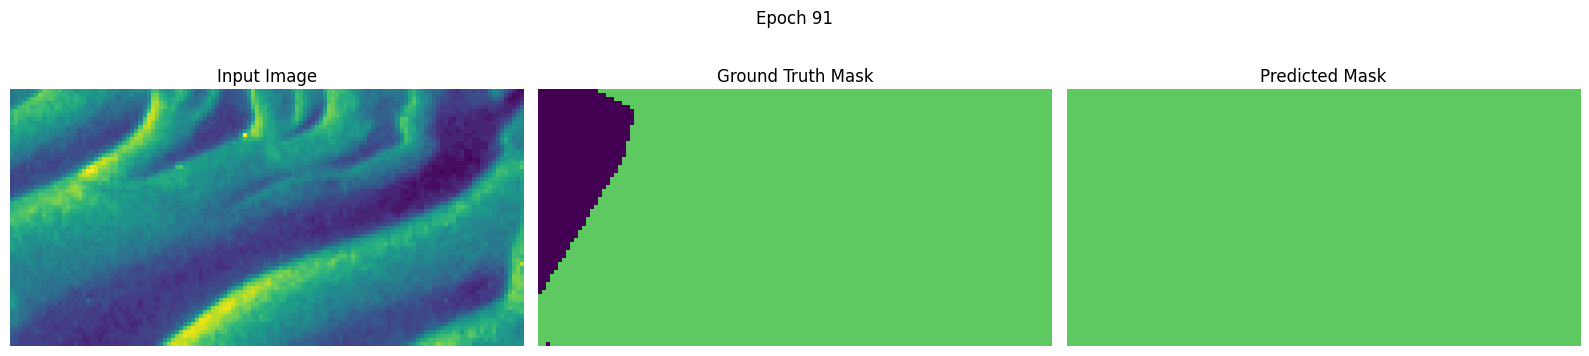

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6789 - loss: 1.0093 - mean_iou: 0.6341 - val_accuracy: 0.6741 - val_loss: 1.2405 - val_mean_iou: 0.5849 - learning_rate: 4.2875e-05
Epoch 92/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6827 - loss: 1.0533 - mean_iou: 0.6456 - val_accuracy: 0.6772 - val_loss: 1.2354 - val_mean_iou: 0.5907 - learning_rate: 4.2875e-05
Epoch 93/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6873 - loss: 1.0292 - mean_iou: 0.6480 - val_accuracy: 0.6752 - val_loss: 1.2385 - val_mean_iou: 0.5867 - learning_rate: 4.2875e-05
Epoch 94/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6895 - loss: 1.0643 - mean_iou: 0.6485 - val_accuracy: 0.6748 - val_loss: 1.2363 - val_mean_iou: 0.5867 - learning_rate: 4.2875e-05
Epoch 95/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6887 - loss: 1.0128 - mean_iou: 0.6642 - val_accuracy: 0.6743 - val_loss: 1.2370 - val_mean_iou: 0.5865 - learning_rate: 4.2875e-05
Epoch 96/500
60/60

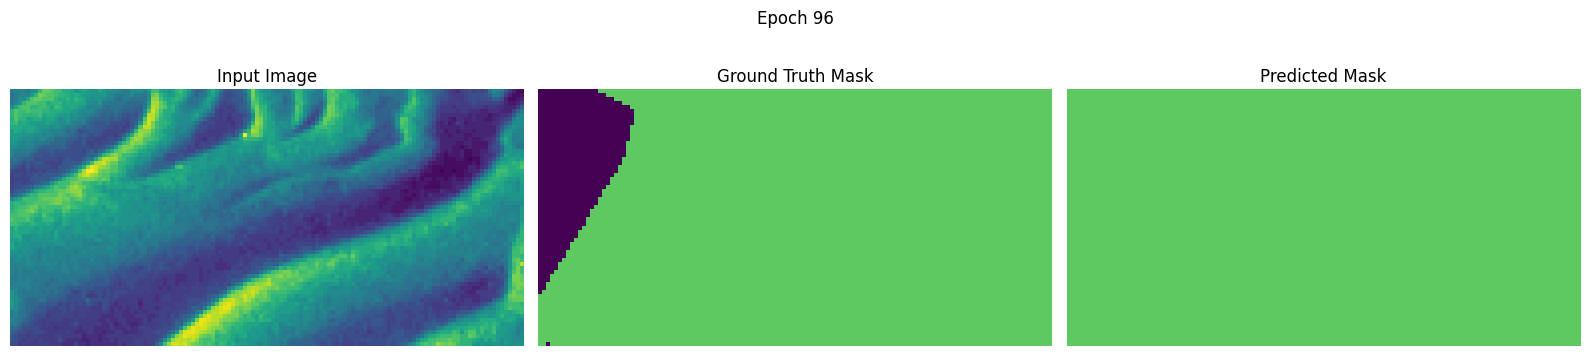

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6810 - loss: 1.0768 - mean_iou: 0.6396 - val_accuracy: 0.6731 - val_loss: 1.2399 - val_mean_iou: 0.5838 - learning_rate: 4.2875e-05
Epoch 97/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6854 - loss: 1.0175 - mean_iou: 0.6619 - val_accuracy: 0.6679 - val_loss: 1.2416 - val_mean_iou: 0.5758 - learning_rate: 4.2875e-05
Epoch 98/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6937 - loss: 1.0313 - mean_iou: 0.6657 - val_accuracy: 0.6748 - val_loss: 1.2381 - val_mean_iou: 0.5859 - learning_rate: 4.2875e-05
Epoch 99/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6884 - loss: 1.0168 - mean_iou: 0.6632 - val_accuracy: 0.6727 - val_loss: 1.2394 - val_mean_iou: 0.5837 - learning_rate: 4.2875e-05
Epoch 100/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6846 - loss: 1.0360 - mean_iou: 0.6504 - val_accuracy: 0.6748 - val_loss: 1.2378 - val_mean_iou: 0.5867 - learning_rate: 4.2875e-05
Epoch 101/500
60/

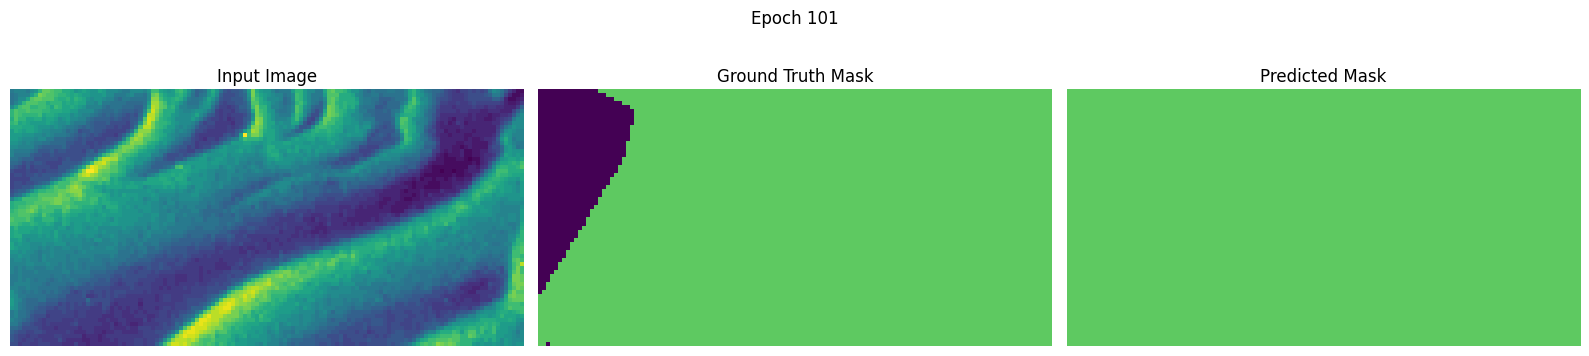

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.6792 - loss: 1.0461 - mean_iou: 0.6423 - val_accuracy: 0.6750 - val_loss: 1.2384 - val_mean_iou: 0.5863 - learning_rate: 4.2875e-05
Epoch 102/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6998 - loss: 1.0021 - mean_iou: 0.6827 - val_accuracy: 0.6763 - val_loss: 1.2366 - val_mean_iou: 0.5886 - learning_rate: 1.5006e-05
Epoch 103/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6880 - loss: 1.0180 - mean_iou: 0.6481 - val_accuracy: 0.6763 - val_loss: 1.2365 - val_mean_iou: 0.5886 - learning_rate: 1.5006e-05
Epoch 104/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6974 - loss: 1.0353 - mean_iou: 0.6732 - val_accuracy: 0.6745 - val_loss: 1.2377 - val_mean_iou: 0.5860 - learning_rate: 1.5006e-05
Epoch 105/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6814 - loss: 1.0194 - mean_iou: 0.6566 - val_accuracy: 0.6728 - val_loss: 1.2392 - val_mean_iou: 0.5831 - learning_rate: 1.5006e-05
Epoch 106/500


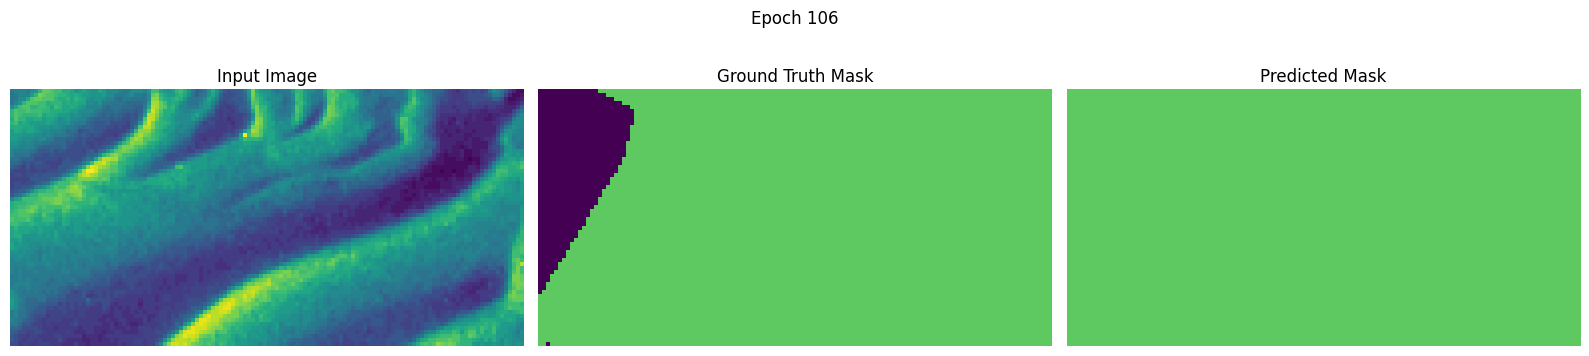

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.6935 - loss: 1.0433 - mean_iou: 0.6718 - val_accuracy: 0.6751 - val_loss: 1.2367 - val_mean_iou: 0.5869 - learning_rate: 1.5006e-05
Epoch 107/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6935 - loss: 1.0125 - mean_iou: 0.6738 - val_accuracy: 0.6745 - val_loss: 1.2372 - val_mean_iou: 0.5859 - learning_rate: 1.5006e-05
Epoch 108/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6862 - loss: 1.0250 - mean_iou: 0.6545 - val_accuracy: 0.6746 - val_loss: 1.2382 - val_mean_iou: 0.5860 - learning_rate: 1.5006e-05
Epoch 109/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6902 - loss: 1.0530 - mean_iou: 0.6524 - val_accuracy: 0.6757 - val_loss: 1.2376 - val_mean_iou: 0.5875 - learning_rate: 1.5006e-05
Epoch 110/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6968 - loss: 1.0231 - mean_iou: 0.6712 - val_accuracy: 0.6744 - val_loss: 1.2380 - val_mean_iou: 0.5858 - learning_rate: 1.5006e-05
Epoch 111/500


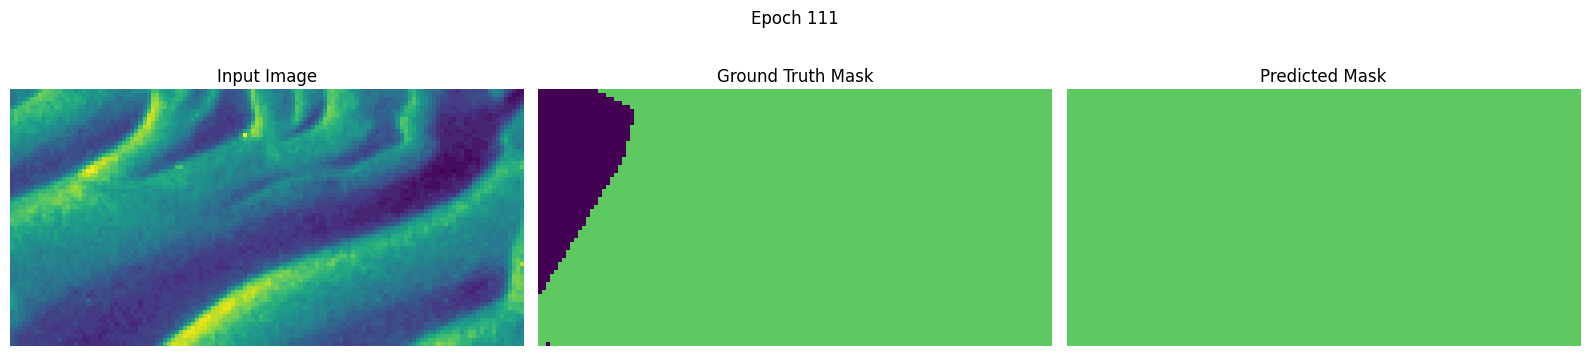

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6959 - loss: 1.0572 - mean_iou: 0.6605 - val_accuracy: 0.6750 - val_loss: 1.2378 - val_mean_iou: 0.5868 - learning_rate: 1.5006e-05
Epoch 112/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6852 - loss: 1.0208 - mean_iou: 0.6516 - val_accuracy: 0.6740 - val_loss: 1.2389 - val_mean_iou: 0.5849 - learning_rate: 1.5006e-05
Epoch 113/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6826 - loss: 1.0306 - mean_iou: 0.6411 - val_accuracy: 0.6752 - val_loss: 1.2379 - val_mean_iou: 0.5867 - learning_rate: 1.5006e-05
Epoch 114/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6886 - loss: 1.0663 - mean_iou: 0.6657 - val_accuracy: 0.6760 - val_loss: 1.2368 - val_mean_iou: 0.5884 - learning_rate: 1.5006e-05
Epoch 115/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6842 - loss: 1.0054 - mean_iou: 0.6582 - val_accuracy: 0.6755 - val_loss: 1.2374 - val_mean_iou: 0.5875 - learning_rate: 1.5006e-05
Epoch 116/500


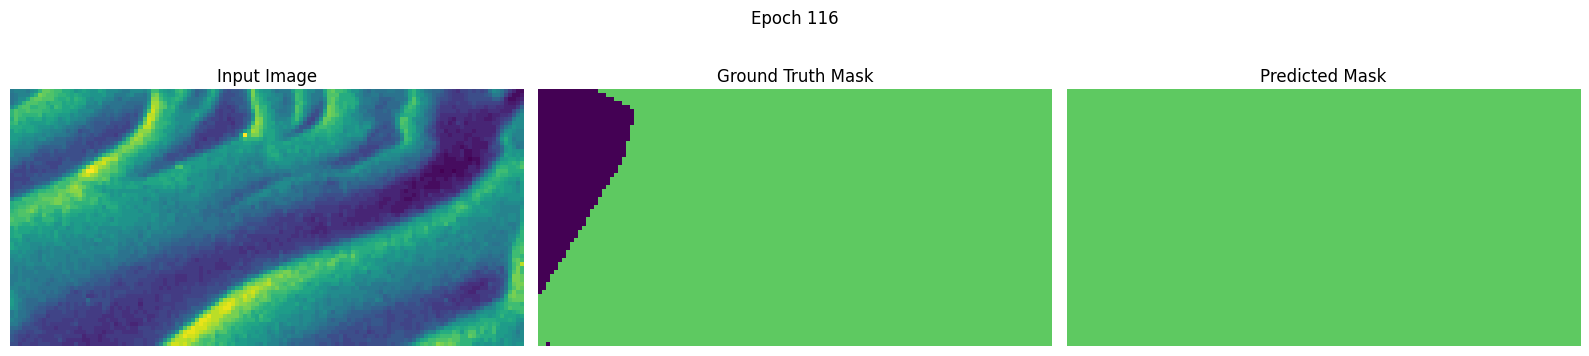

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.6881 - loss: 1.0356 - mean_iou: 0.6628 - val_accuracy: 0.6773 - val_loss: 1.2361 - val_mean_iou: 0.5903 - learning_rate: 1.5006e-05
Epoch 117/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6928 - loss: 1.0351 - mean_iou: 0.6627 - val_accuracy: 0.6774 - val_loss: 1.2362 - val_mean_iou: 0.5908 - learning_rate: 1.5006e-05
Epoch 118/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6844 - loss: 1.0424 - mean_iou: 0.6441 - val_accuracy: 0.6772 - val_loss: 1.2360 - val_mean_iou: 0.5910 - learning_rate: 1.5006e-05
Epoch 119/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6883 - loss: 1.0189 - mean_iou: 0.6691 - val_accuracy: 0.6773 - val_loss: 1.2362 - val_mean_iou: 0.5906 - learning_rate: 1.5006e-05
Epoch 120/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6855 - loss: 1.0567 - mean_iou: 0.6614 - val_accuracy: 0.6764 - val_loss: 1.2375 - val_mean_iou: 0.5891 - learning_rate: 1.5006e-05
Epoch 121/500


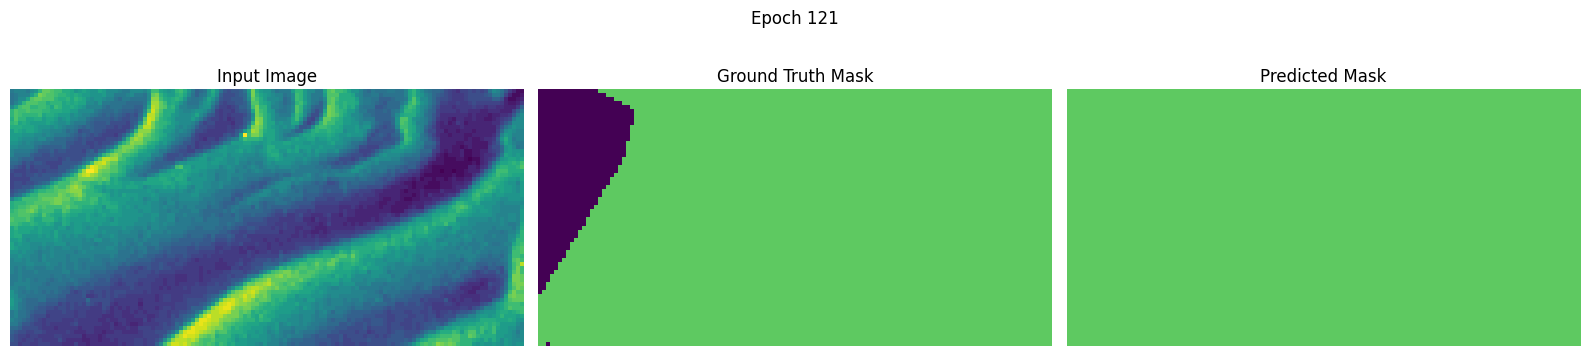

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6950 - loss: 1.0391 - mean_iou: 0.6696 - val_accuracy: 0.6763 - val_loss: 1.2370 - val_mean_iou: 0.5892 - learning_rate: 1.5006e-05
Epoch 122/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6901 - loss: 1.0696 - mean_iou: 0.6488 - val_accuracy: 0.6779 - val_loss: 1.2350 - val_mean_iou: 0.5917 - learning_rate: 1.5006e-05
Epoch 123/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6851 - loss: 1.0170 - mean_iou: 0.6579 - val_accuracy: 0.6764 - val_loss: 1.2367 - val_mean_iou: 0.5895 - learning_rate: 1.5006e-05
Epoch 124/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6889 - loss: 1.0472 - mean_iou: 0.6540 - val_accuracy: 0.6777 - val_loss: 1.2357 - val_mean_iou: 0.5910 - learning_rate: 1.5006e-05
Epoch 125/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6851 - loss: 0.9913 - mean_iou: 0.6511 - val_accuracy: 0.6796 - val_loss: 1.2333 - val_mean_iou: 0.5941 - learning_rate: 1.5006e-05
Epoch 126/500


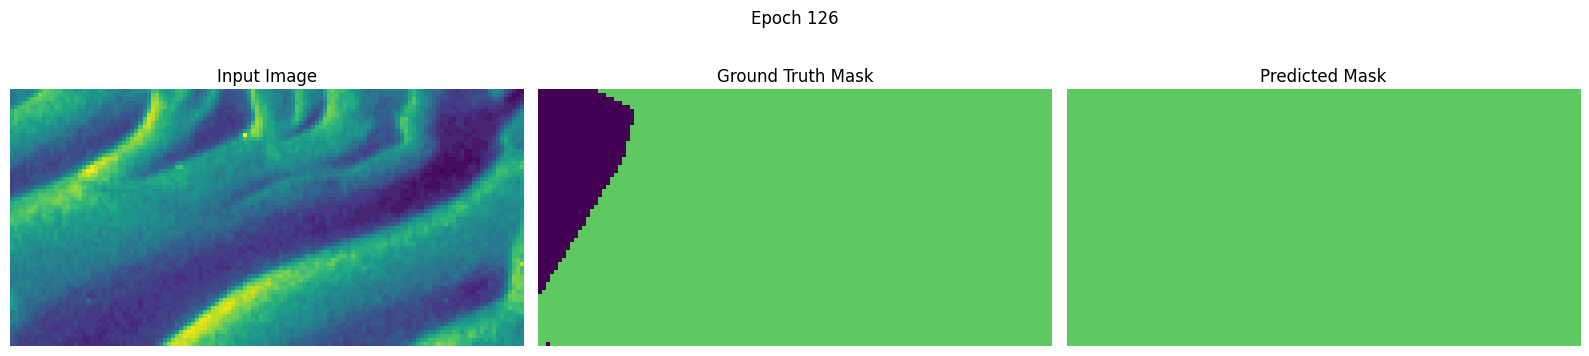

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.6863 - loss: 1.0275 - mean_iou: 0.6362 - val_accuracy: 0.6779 - val_loss: 1.2336 - val_mean_iou: 0.5915 - learning_rate: 1.5006e-05
Epoch 127/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6895 - loss: 1.0129 - mean_iou: 0.6643 - val_accuracy: 0.6775 - val_loss: 1.2342 - val_mean_iou: 0.5909 - learning_rate: 5.2522e-06
Epoch 128/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6862 - loss: 0.9978 - mean_iou: 0.6486 - val_accuracy: 0.6769 - val_loss: 1.2350 - val_mean_iou: 0.5898 - learning_rate: 5.2522e-06
Epoch 129/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6864 - loss: 1.0428 - mean_iou: 0.6544 - val_accuracy: 0.6768 - val_loss: 1.2351 - val_mean_iou: 0.5898 - learning_rate: 5.2522e-06
Epoch 130/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6944 - loss: 1.0443 - mean_iou: 0.6591 - val_accuracy: 0.6761 - val_loss: 1.2363 - val_mean_iou: 0.5885 - learning_rate: 5.2522e-06
Epoch 131/500


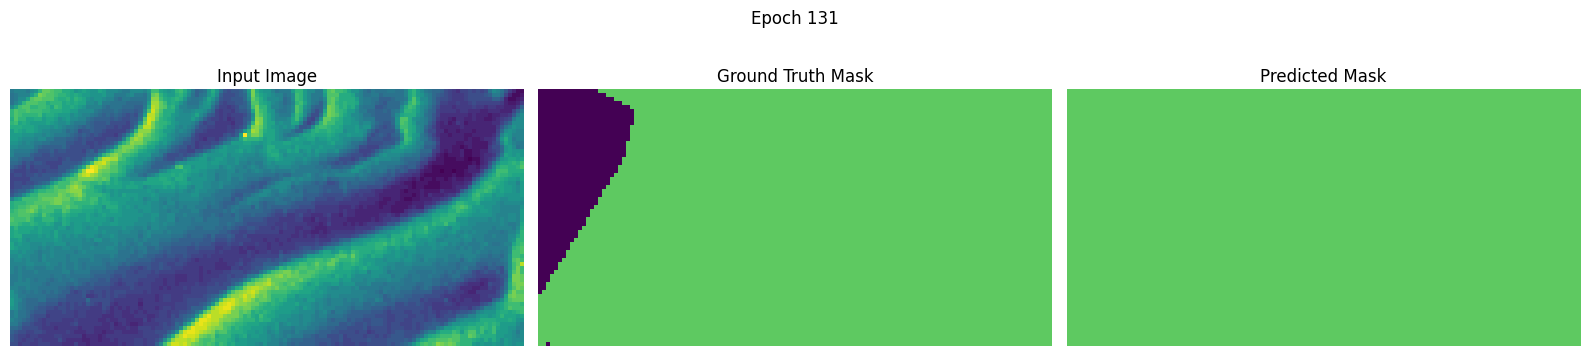

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.6891 - loss: 1.0316 - mean_iou: 0.6582 - val_accuracy: 0.6767 - val_loss: 1.2357 - val_mean_iou: 0.5895 - learning_rate: 5.2522e-06
Epoch 132/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6950 - loss: 1.0262 - mean_iou: 0.6611 - val_accuracy: 0.6763 - val_loss: 1.2359 - val_mean_iou: 0.5889 - learning_rate: 5.2522e-06
Epoch 133/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6905 - loss: 1.0503 - mean_iou: 0.6718 - val_accuracy: 0.6768 - val_loss: 1.2356 - val_mean_iou: 0.5896 - learning_rate: 5.2522e-06
Epoch 134/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6936 - loss: 1.0170 - mean_iou: 0.6614 - val_accuracy: 0.6764 - val_loss: 1.2359 - val_mean_iou: 0.5890 - learning_rate: 5.2522e-06
Epoch 135/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6924 - loss: 1.0353 - mean_iou: 0.6624 - val_accuracy: 0.6767 - val_loss: 1.2362 - val_mean_iou: 0.5894 - learning_rate: 5.2522e-06
Epoch 136/500


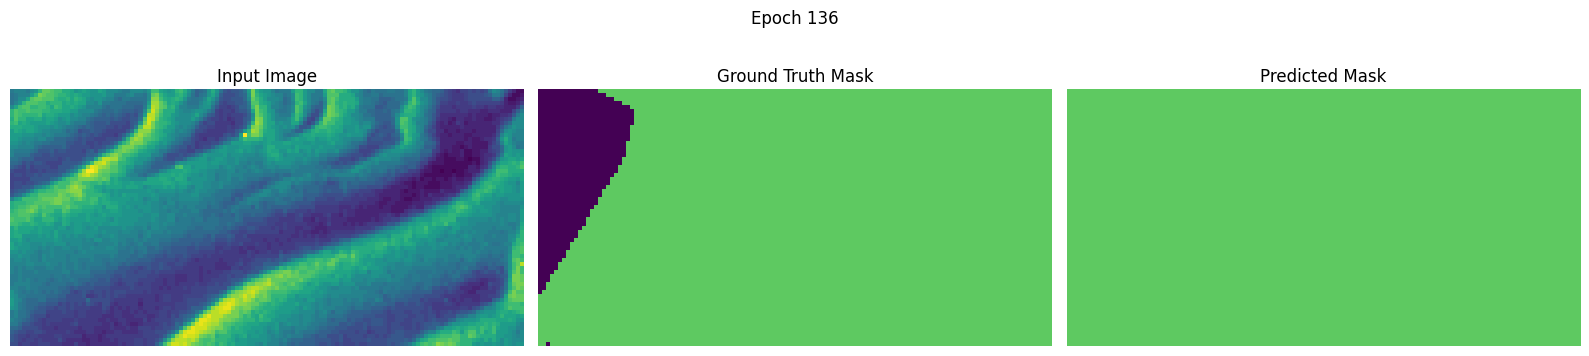

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.6802 - loss: 1.0371 - mean_iou: 0.6405 - val_accuracy: 0.6765 - val_loss: 1.2362 - val_mean_iou: 0.5891 - learning_rate: 5.2522e-06
Epoch 137/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6936 - loss: 1.0425 - mean_iou: 0.6635 - val_accuracy: 0.6771 - val_loss: 1.2354 - val_mean_iou: 0.5901 - learning_rate: 5.2522e-06
Epoch 138/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6949 - loss: 1.0209 - mean_iou: 0.6667 - val_accuracy: 0.6768 - val_loss: 1.2356 - val_mean_iou: 0.5895 - learning_rate: 5.2522e-06
Epoch 139/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6987 - loss: 1.0257 - mean_iou: 0.6717 - val_accuracy: 0.6762 - val_loss: 1.2364 - val_mean_iou: 0.5885 - learning_rate: 5.2522e-06
Epoch 140/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6880 - loss: 1.0169 - mean_iou: 0.6662 - val_accuracy: 0.6766 - val_loss: 1.2362 - val_mean_iou: 0.5892 - learning_rate: 5.2522e-06
Epoch 141/500


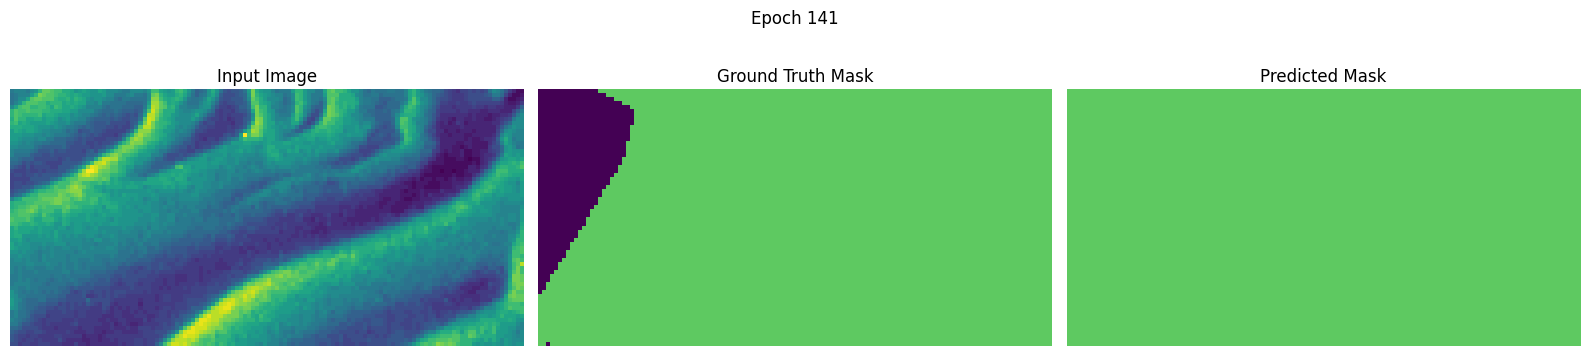

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.6917 - loss: 0.9992 - mean_iou: 0.6631 - val_accuracy: 0.6768 - val_loss: 1.2356 - val_mean_iou: 0.5897 - learning_rate: 5.2522e-06
Epoch 142/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6947 - loss: 1.0438 - mean_iou: 0.6788 - val_accuracy: 0.6762 - val_loss: 1.2364 - val_mean_iou: 0.5888 - learning_rate: 5.2522e-06
Epoch 143/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6907 - loss: 1.0632 - mean_iou: 0.6553 - val_accuracy: 0.6769 - val_loss: 1.2352 - val_mean_iou: 0.5900 - learning_rate: 5.2522e-06
Epoch 144/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6909 - loss: 1.0582 - mean_iou: 0.6568 - val_accuracy: 0.6774 - val_loss: 1.2344 - val_mean_iou: 0.5910 - learning_rate: 5.2522e-06
Epoch 145/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6940 - loss: 1.0172 - mean_iou: 0.6814 - val_accuracy: 0.6770 - val_loss: 1.2348 - val_mean_iou: 0.5905 - learning_rate: 5.2522e-06
Epoch 146/500


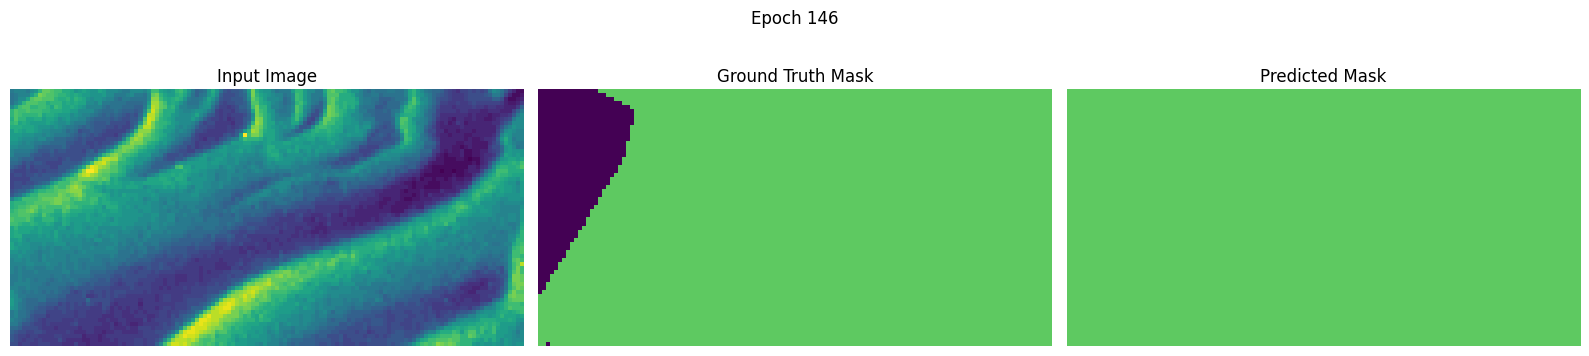

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.6882 - loss: 1.0344 - mean_iou: 0.6499 - val_accuracy: 0.6764 - val_loss: 1.2356 - val_mean_iou: 0.5895 - learning_rate: 5.2522e-06
Epoch 147/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6883 - loss: 1.0260 - mean_iou: 0.6703 - val_accuracy: 0.6767 - val_loss: 1.2355 - val_mean_iou: 0.5897 - learning_rate: 5.2522e-06
Epoch 148/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6894 - loss: 1.0180 - mean_iou: 0.6603 - val_accuracy: 0.6762 - val_loss: 1.2359 - val_mean_iou: 0.5892 - learning_rate: 5.2522e-06
Epoch 149/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6997 - loss: 1.0215 - mean_iou: 0.6599 - val_accuracy: 0.6765 - val_loss: 1.2355 - val_mean_iou: 0.5899 - learning_rate: 5.2522e-06
Epoch 150/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6944 - loss: 1.0263 - mean_iou: 0.6667 - val_accuracy: 0.6762 - val_loss: 1.2365 - val_mean_iou: 0.5891 - learning_rate: 5.2522e-06
Epoch 151/500


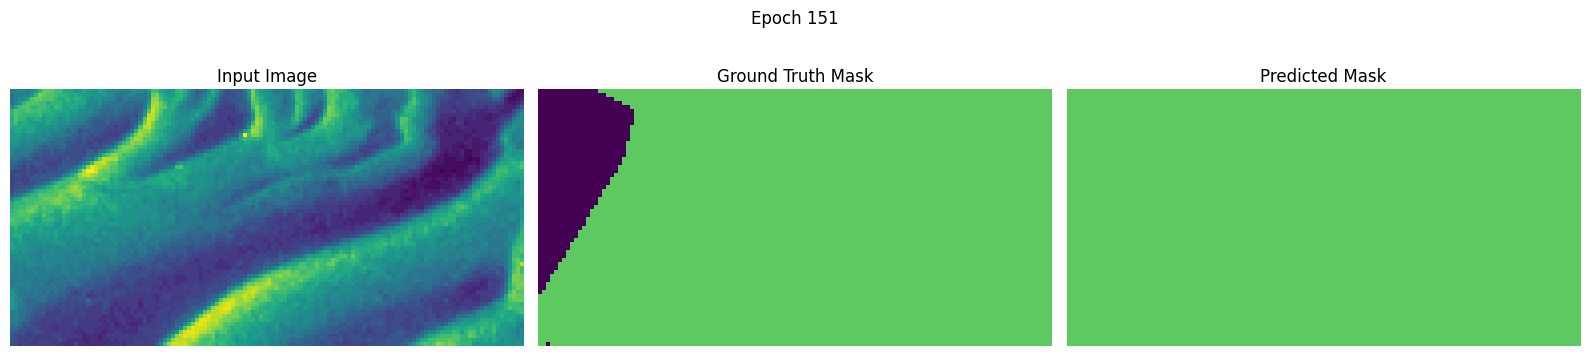

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6864 - loss: 1.0289 - mean_iou: 0.6585 - val_accuracy: 0.6764 - val_loss: 1.2362 - val_mean_iou: 0.5894 - learning_rate: 5.2522e-06
Epoch 152/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6875 - loss: 1.0531 - mean_iou: 0.6640 - val_accuracy: 0.6767 - val_loss: 1.2360 - val_mean_iou: 0.5898 - learning_rate: 1.8383e-06
Epoch 153/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.6959 - loss: 1.0179 - mean_iou: 0.6673 - val_accuracy: 0.6771 - val_loss: 1.2357 - val_mean_iou: 0.5905 - learning_rate: 1.8383e-06
Epoch 154/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6893 - loss: 1.0457 - mean_iou: 0.6548 - val_accuracy: 0.6776 - val_loss: 1.2351 - val_mean_iou: 0.5914 - learning_rate: 1.8383e-06
Epoch 155/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6854 - loss: 1.0508 - mean_iou: 0.6493 - val_accuracy: 0.6780 - val_loss: 1.2341 - val_mean_iou: 0.5921 - learning_rate: 1.8383e-06
Epoch 156/500


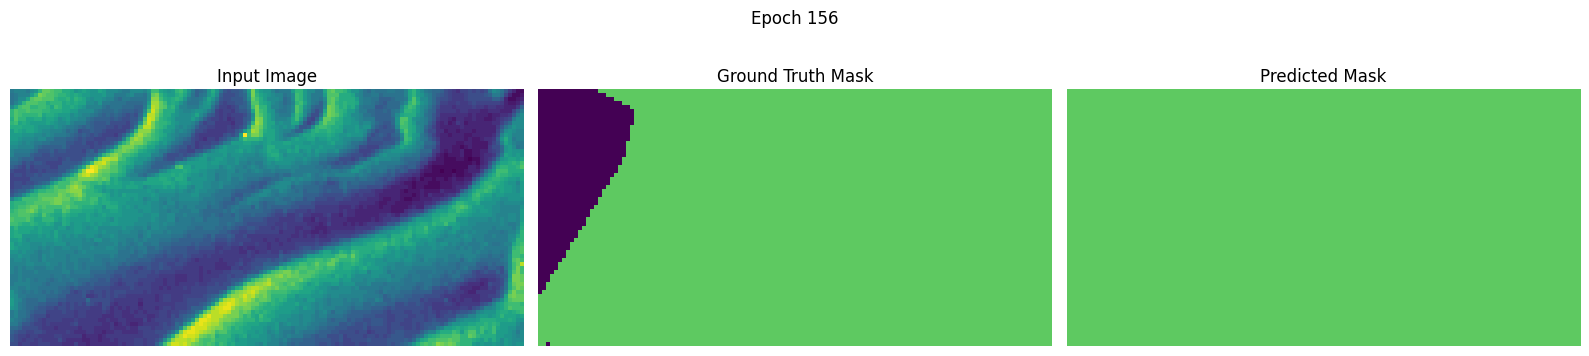

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6804 - loss: 1.0400 - mean_iou: 0.6491 - val_accuracy: 0.6777 - val_loss: 1.2346 - val_mean_iou: 0.5914 - learning_rate: 1.8383e-06
Epoch 157/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6715 - loss: 0.9842 - mean_iou: 0.6416 - val_accuracy: 0.6776 - val_loss: 1.2349 - val_mean_iou: 0.5912 - learning_rate: 1.8383e-06
Epoch 158/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6865 - loss: 1.0169 - mean_iou: 0.6454 - val_accuracy: 0.6772 - val_loss: 1.2351 - val_mean_iou: 0.5907 - learning_rate: 1.8383e-06
Epoch 159/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6934 - loss: 1.0163 - mean_iou: 0.6751 - val_accuracy: 0.6767 - val_loss: 1.2357 - val_mean_iou: 0.5899 - learning_rate: 1.8383e-06
Epoch 160/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6929 - loss: 1.0394 - mean_iou: 0.6640 - val_accuracy: 0.6772 - val_loss: 1.2354 - val_mean_iou: 0.5906 - learning_rate: 1.8383e-06
Epoch 161/500


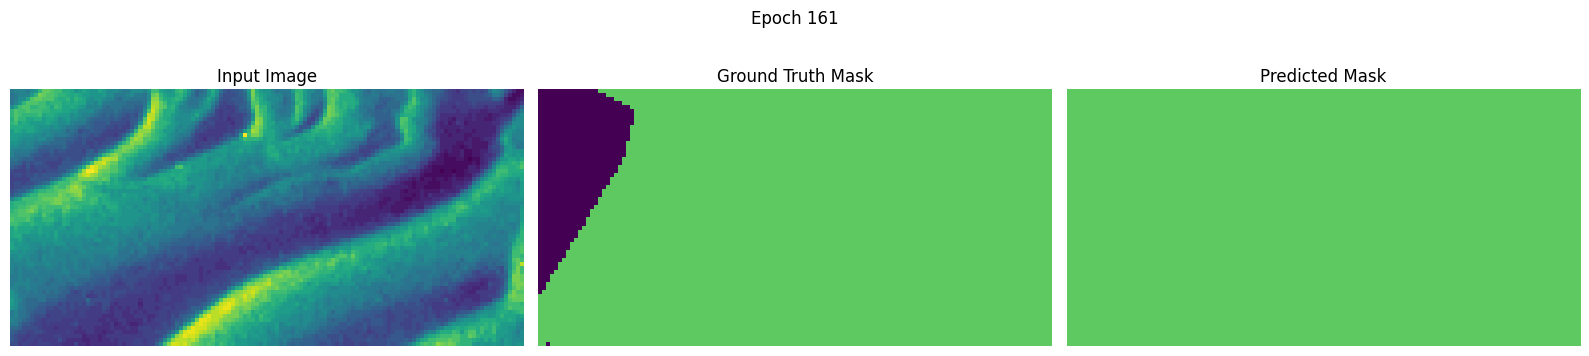

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6900 - loss: 1.0583 - mean_iou: 0.6566 - val_accuracy: 0.6775 - val_loss: 1.2352 - val_mean_iou: 0.5910 - learning_rate: 1.8383e-06
Epoch 162/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6862 - loss: 1.0547 - mean_iou: 0.6551 - val_accuracy: 0.6770 - val_loss: 1.2355 - val_mean_iou: 0.5903 - learning_rate: 1.8383e-06
Epoch 163/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6786 - loss: 1.0448 - mean_iou: 0.6692 - val_accuracy: 0.6771 - val_loss: 1.2351 - val_mean_iou: 0.5905 - learning_rate: 1.8383e-06
Epoch 164/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6880 - loss: 1.0297 - mean_iou: 0.6659 - val_accuracy: 0.6767 - val_loss: 1.2359 - val_mean_iou: 0.5897 - learning_rate: 1.8383e-06
Epoch 165/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6894 - loss: 1.0504 - mean_iou: 0.6622 - val_accuracy: 0.6764 - val_loss: 1.2361 - val_mean_iou: 0.5894 - learning_rate: 1.8383e-06


In [33]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, vizcallback, reduce_lr],
    verbose=1
).history

In [34]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

Final validation Mean Intersection Over Union: 59.41%


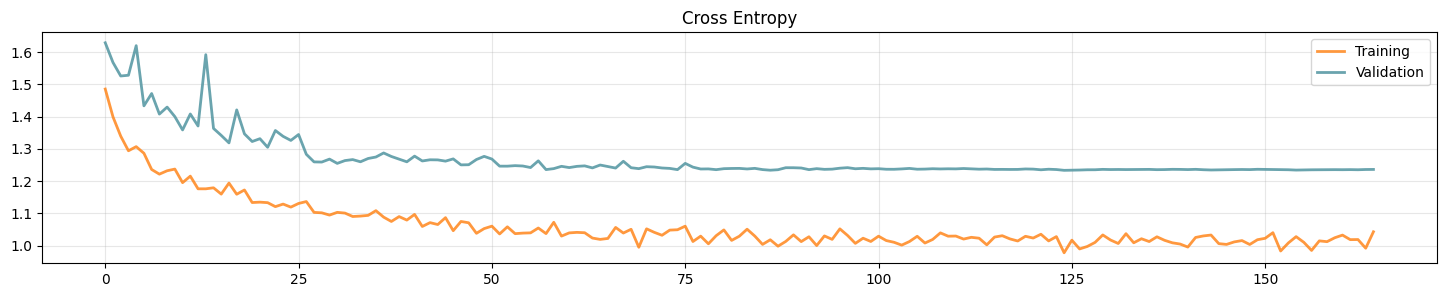

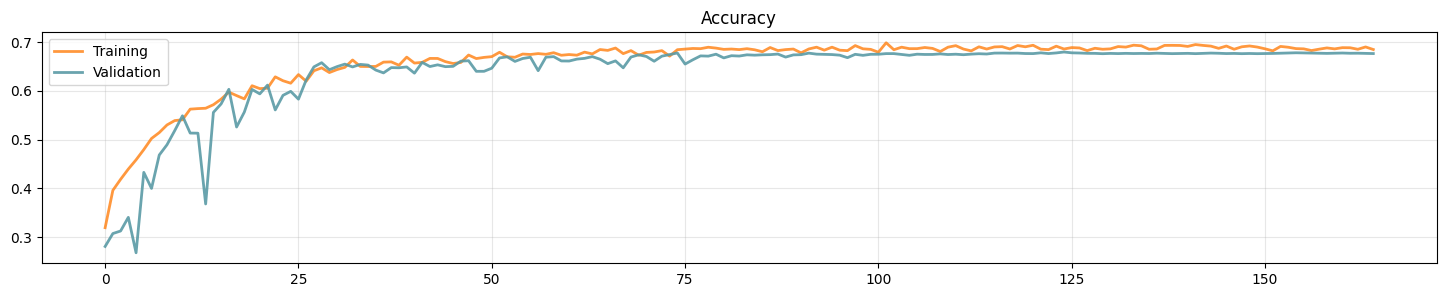

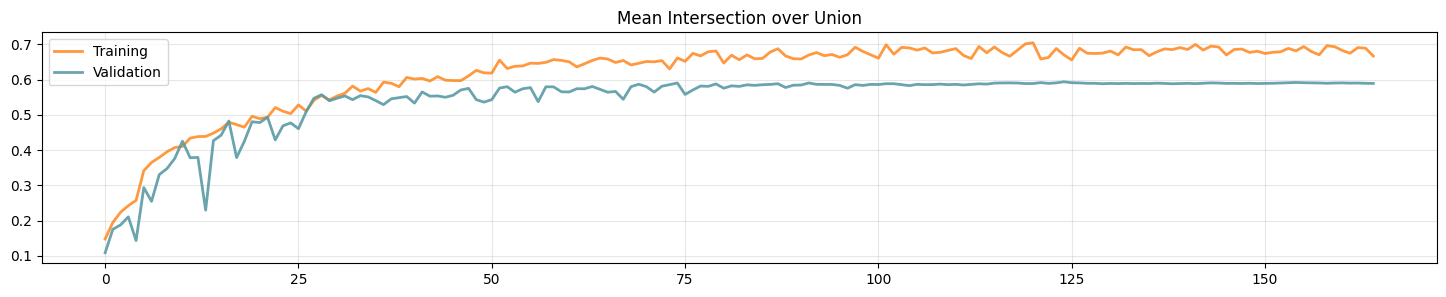

In [35]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [36]:
# Save model
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

/opt/conda/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     loss=lambda y_true, y_pred: combined_loss(
                  y_true, 
                  y_pred, 
                  dice_weight=1.5, 
                  focal_weight=2.0, 
                  boundary_weight=0.5, 
                  class_weights=list(capped_weights.values())
              ),

  return {key: serialize_keras_object(value) for key, value in obj.items()}


Model saved to model_241208_124742.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [37]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [38]:
# Load UNet model without compiling
# model_filename = "model_241207_162509.keras"
model = tfk.models.load_model(model_filename, compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=lambda y_true, y_pred: combined_loss(
                  y_true, 
                  y_pred, 
                  dice_weight=1.5, 
                  focal_weight=2.0, 
                  boundary_weight=0.5, 
                  class_weights=list(capped_weights.values())
              ),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print(f"Model loaded from {model_filename}")

Model loaded from model_241208_124742.keras


In [39]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

Test Accuracy: 0.6449
Test Mean Intersection over Union: 0.585


In [40]:
import numpy as np
import tensorflow as tf

def apply_tta(image, model, num_classes):
    """
    Apply Test-Time Augmentation (TTA) for semantic segmentation.
    
    Args:
        image (numpy.ndarray): Input grayscale image of shape (H, W, 1).
        model (tf.keras.Model): Trained segmentation model.
        num_classes (int): Number of classes in the segmentation task.
    
    Returns:
        numpy.ndarray: Averaged segmentation mask predictions of shape (H, W, num_classes).
    """
    augmentations = [
        lambda x: x,  # Original
        lambda x: tf.image.flip_left_right(x),  # Horizontal flip
        lambda x: tf.image.flip_up_down(x),  # Vertical flip
        lambda x: tf.image.rot90(x, k=1),  # 90-degree rotation
        lambda x: tf.image.rot90(x, k=2),  # 180-degree rotation
        lambda x: tf.image.rot90(x, k=3),  # 270-degree rotation
    ]
    
    # Multi-scale augmentation factors
    scales = [0.75, 1.0, 1.25]
    
    height, width, channels = image.shape
    predictions = []

    for scale in scales:
        resized_image = tf.image.resize(image, (int(height * scale), int(width * scale)))
        augmented_images = [aug(resized_image) for aug in augmentations]
        augmented_images = [tf.image.resize(aug_img, (height, width)) for aug_img in augmented_images]  # Resize back to original size
        augmented_images = tf.stack(augmented_images)  # Stack images to create a batch
        predictions_batch = model.predict(augmented_images)  # Predict on the batch
        predictions.extend(predictions_batch)  # Add batch predictions to the list
    
    # Average predictions across augmentations
    combined_prediction = np.mean(predictions, axis=0)
    
    # Return the final mask (softmax for probabilities or argmax for final class assignment)
    return combined_prediction

# Apply TTA
def predict_with_tta(model, X_test):
    preds = []
    for image in X_test:
        tta_prediction = apply_tta(image, model, num_classes=NUM_CLASSES)
        # Convert probabilities to class labels
        preds.append(np.argmax(tta_prediction, axis=-1))  # Shape (H, W)
    return np.array(preds)

# Use the function to predict with TTA
preds = predict_with_tta(model, X_test)
print(f"TTA Predictions shape: {preds.shape}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━

In [41]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [42]:
# Create and download the csv submission file
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

if IN_COLAB:
    from google.colab import files
    files.download(submission_filename)